In [1]:
import numpy as np
import json
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)
import pandas as pd
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import sys
import collections
import torch
from toytask_utils import make_tasks, all_divisions
from divergence_utils import SymmetricDefiniteMatrix
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

csv_id = None

# Generate Initial Data

In [2]:
n_samples = 100 # number of times to resample each class
x_values = [-1,1] # valid causal x values
y_values = [i for i in range(5)] # valid causal y values
std = 0.1 # standard deviation of noise along causal dims
cov = 0.2 # covariance between causal dims

varbs = []
for x in x_values:
    for y in y_values:
        varbs.append([x,y])
varbs = np.asarray(varbs)

samples = []
og_varbs = []
xmean = 0
ymean = 0
for _ in range(n_samples):
    samp = varbs.copy().astype(float)
    og_varbs.append(varbs.copy())
    samp[:,0] += cov*samp[:,1]
    noise = std*np.random.randn(*samp.shape)
    samp = samp + noise
    samples.append(samp)
samples = np.vstack(samples)
samples = samples - samples.mean(0)
og_varbs = np.vstack(og_varbs)
print(samples.shape)

(1000, 2)


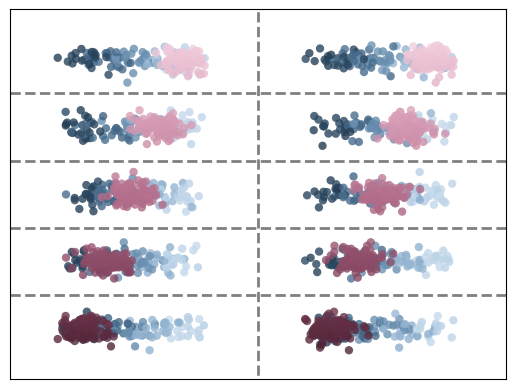

In [3]:
df = pd.DataFrame({
    "x": samples[:,0],
    "y": samples[:,1],
    "hue": samples[:,1],
})
df["x"] = (df["x"]-np.mean(df["x"]))
df["hue"] = df["hue"]-np.min(df["hue"])
df["hue"] = df["hue"]/np.max(df["hue"])


fontsize=25
legendsize = 25
alpha = 0.8
dark = 0.2
light = 0.85
rot = 0
thickness = 2
fig = plt.figure()
ax = plt.gca()

intrv_df = df.copy()
intrv_df["y"] = np.asarray(intrv_df["y"])[np.random.permutation(len(intrv_df)).astype(int)]
intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#intrv_cmap = sns.dark_palette("blue", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=intrv_df, ax=ax, hue="hue", palette=intrv_cmap, edgecolor="none")

native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#native_cmap = sns.dark_palette("red", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=df, ax=ax, hue="hue", palette=native_cmap, edgecolor="none")
                #hue="hue", palette="blue")
    
## y divider
ax.plot([0,0],[-3,3], "k--", alpha=0.5, linewidth=thickness)
# x dividers
for i in y_values[:-1]:
    y = i+0.5-2
    ax.plot([-2,2],[y,y], "k--", alpha=0.5, linewidth=thickness)
plt.xlim([-2,2])
plt.ylim([-2.75,2.75])

plt.xlabel("", fontsize=fontsize)
plt.ylabel("", fontsize=fontsize)

plt.xticks([], fontsize=fontsize)
plt.yticks([], fontsize=fontsize)

# # Manually create colorbars / legend patches
# native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
# intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)

# Legend handles: colored rectangles with labels
#native_patch = mpatches.Patch(color=native_cmap(0.8), label="Native")
#intrv_patch = mpatches.Patch(color=intrv_cmap(0.8), label="Intervened")

#ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
plt.legend().set_visible(False)
#plt.savefig("figs/example_divergence.png", dpi=600, bbox_inches="tight")

plt.show()

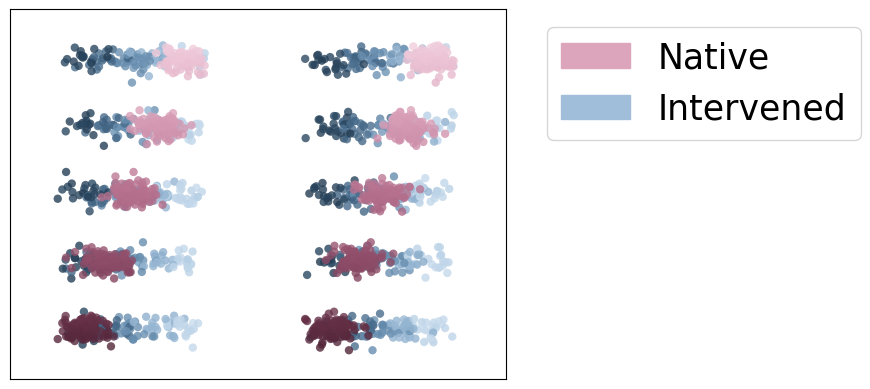

In [4]:
import matplotlib.patches as mpatches
import matplotlib as mpl

df = pd.DataFrame({
    "x": samples[:,0],
    "y": samples[:,1],
    "hue": samples[:,1],
})
df["x"] = (df["x"]-np.mean(df["x"]))
df["hue"] = df["hue"]-np.min(df["hue"])
df["hue"] = df["hue"]/np.max(df["hue"])



fontsize=25
legendsize = 25
alpha = 0.8
dark = 0.2
light = 0.85
rot = 0
fig = plt.figure()
ax = plt.gca()

intrv_df = df.copy()
intrv_df["y"] = np.asarray(intrv_df["y"])[np.random.permutation(len(intrv_df)).astype(int)]
intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#intrv_cmap = sns.dark_palette("blue", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=intrv_df, ax=ax, hue="hue", palette=intrv_cmap, edgecolor="none")

native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#native_cmap = sns.dark_palette("red", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=df, ax=ax, hue="hue", palette=native_cmap, edgecolor="none")
                #hue="hue", palette="blue")
    
## y divider
#ax.plot([0,0],[-1,5], "k--", alpha=0.5)
## x dividers
#for i in y_values[:-1]:
#    y = i+0.5
#    ax.plot([-2,2],[y,y], "k--", alpha=0.5)
plt.xlim([-2,2])
plt.ylim([-2.75,2.75])

plt.xlabel("", fontsize=fontsize)
plt.ylabel("", fontsize=fontsize)

plt.xticks([], fontsize=fontsize)
plt.yticks([], fontsize=fontsize)

# # Manually create colorbars / legend patches
# native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
# intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)

# Legend handles: colored rectangles with labels
native_patch = mpatches.Patch(color=native_cmap(0.8), label="Native")
intrv_patch = mpatches.Patch(color=intrv_cmap(0.8), label="Intervened")

ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
#plt.savefig("figs/legend.png", dpi=600, bbox_inches="tight")

plt.show()

In [5]:
from geomloss import SamplesLoss
kwargs = {
    "loss": "sinkhorn",
    "p": 2,
    "blur": 0.05,
}
loss_fn = SamplesLoss(**kwargs)

def compute_emd(X,Y):
    return loss_fn(X.float(),Y.float())


# CL Loss

In [6]:
print(og_varbs.shape)
print(samples.shape)

(1000, 2)
(1000, 2)


In [7]:
def quick_plot(
    natty,
    intrv,
    natty_classes=None,
    intrv_classes=None,
    save_name=None,
    incl_legend=False,
    incl_dividers=True,
    xlim=[-2,2],
    ylim=[-2.75,2.75],
    incl_ticks=False,
    labels=["Native", "Intervened"],
    intrv_cmap=None,
    native_cmap=None,
    intrv_color=None,
    native_color=None,
    intrv_alpha = 0.95,
    native_alpha = 0.6,
    thickness=2,
    dash_alpha=0.5,
    legendsize = 25,
    dark = 0.2,
    light = 0.85,
    rot = 0,
    y_values=[i+0.5-2 for i in range(5)],
    rot_mtx=None,
    figscale=1,
):
    
    fig = plt.figure(figsize=(3*figscale, 5*figscale))
    ax = plt.gca()
    
    if not incl_ticks:
        plt.xticks([])
        plt.yticks([])
    
    natty = natty.cpu().detach().numpy()
    intrv = intrv.cpu().detach().numpy()
    
    if natty_classes is None:
        if intrv_cmap is None:
            intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if intrv_color is None:
            intrv_color = intrv_cmap(0.8)
        sns.scatterplot(x=intrv[:,0], y=intrv[:,1], alpha=intrv_alpha, ax=ax, color=intrv_color, edgecolor="none")
    elif len(set(intrv_classes))==1:
        if intrv_cmap is None:
            intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if intrv_color is None:
            intrv_color = intrv_cmap(0.8)
        sns.scatterplot(x=intrv[:,0], y=intrv[:,1], alpha=intrv_alpha, ax=ax, color=intrv_color, edgecolor="none")
    else:
        if intrv_cmap is None:
            intrv_cmap = sns.color_palette("pastel")
        sns.scatterplot(
            x=intrv[:,0], y=intrv[:,1],
            alpha=intrv_alpha, ax=ax,
            hue=intrv_classes, palette=intrv_cmap
        )

    if natty_classes is None:
        if native_cmap is None:
            native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if native_color is None:
            native_color = native_cmap(0.8)
        sns.scatterplot(x=natty[:,0], y=natty[:,1], alpha=native_alpha, ax=ax, color=native_color, edgecolor="none")
    elif len(set(natty_classes))==1:
        if native_cmap is None:
            native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if native_color is None:
            native_color = native_cmap(0.8)
        sns.scatterplot(x=natty[:,0], y=natty[:,1], alpha=native_alpha, ax=ax, color=native_color, edgecolor="none")
    else:
        if native_cmap is None:
            native_cmap = sns.color_palette("dark")
        sns.scatterplot(
            x=natty[:,0],
            y=natty[:,1],
            alpha=native_alpha,
            ax=ax,
            hue=natty_classes,
            palette=native_cmap,
            edgecolor="none"
        )
        
    if incl_legend and natty_classes is None:
        native_patch = mpatches.Patch(color=native_color, label=labels[0])
        intrv_patch = mpatches.Patch(color=intrv_color, label=labels[1])
        ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
    elif incl_legend:
        plt.legend()
    else:
        plt.legend().set_visible(False)
        
    ## y divider
    if incl_dividers:
        ax.plot([0,0],[-3,3], "k--", linewidth=thickness, alpha=dash_alpha)
        # x dividers
        for y in y_values[:-1]:
            ax.plot([-2,2],[y,y], "k--", linewidth=thickness, alpha=dash_alpha)
    if rot_mtx is not None:
        vec1 = rot_mtx.weight.data[:2,0]
        vec1 = vec1/vec1.norm()
        vec1 = vec1.cpu().numpy()
        ax.plot([0,3*vec1[0]], [0, 3*vec1[1]], "b--", linewidth=thickness, alpha=1)
        vec2 = rot_mtx.weight.data[:2,1]
        vec2 = vec2/vec2.norm()
        vec2 = vec2.cpu().numpy()
        ax.plot([0,3*vec2[0]], [0, 3*vec2[1]], "b--", linewidth=thickness, alpha=1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    if save_name:
        plt.savefig(save_name, dpi=600, bbox_inches="tight")
    plt.show()    

In [8]:
def rot_fwd(vecs, mtx):
    mdtype = next(mtx.parameters()).dtype
    if mdtype!=vecs.dtype:
        vecs = vecs.double()
    return torch.matmul(vecs, mtx.weight ).float()

def rot_bck(vecs, mtx):
    mdtype = next(mtx.parameters()).dtype
    if mdtype!=vecs.dtype:
        vecs = vecs.double()
    inv = torch.linalg.inv(mtx.weight)
    return torch.matmul(vecs, inv ).float()

def interchange(trg,src,mtx,mask):
    """
    Patches the non-zero masked values from the src
    into the trg vectors in the rotated space.
    
    Args:
        trg: torch tensor (B,D)
        src: torch tensor (B,D)
        mtx: torch module (D,D)
            needs "weight" property
        mask: torch tensor (D,)
            ones denote dimensions that will be transferred
    """
    rot_trg = rot_fwd(trg, mtx)
    rot_src = rot_fwd(src, mtx)
    intrv = rot_trg*(1-mask) + rot_src*mask
    return rot_bck(intrv, mtx)

In [9]:
def normalize_fn(vecs, eps=1e-7):
    return (vecs-vecs.mean(0))/(vecs.std(0)+eps)

In [10]:
def get_classes_from_varbs(varbs, v2class=None):
    if v2class is None:
        v2class = dict()
    classes = []
    for v in varbs.detach().cpu().tolist():
        tup = tuple(v)
        if tup not in v2class:
            v2class[tup] = len(v2class)
        classes.append(v2class[tup])
    return np.asarray(classes), v2class
    

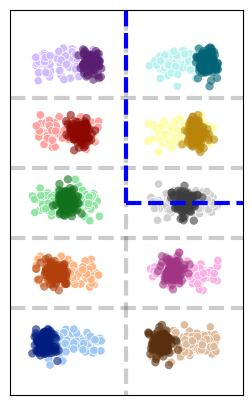

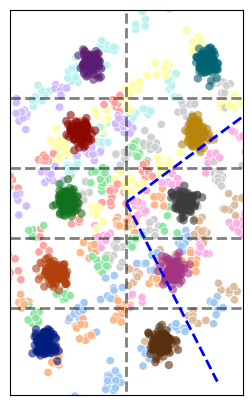

In [11]:
extra_dims = 0
cov = 0
mask_dims = 1

og_varbs = torch.tensor(og_varbs).long()
d = og_varbs.shape[-1] + extra_dims
mask = torch.zeros(d)
mask[:mask_dims] = 1

samples = torch.tensor(samples).float()
noise = torch.randn(len(og_varbs), extra_dims) + cov * torch.randn(len(og_varbs), extra_dims)*og_varbs[:,1:]
natty_varbs = og_varbs.clone()
natty_classes, v2class = get_classes_from_varbs(natty_varbs)
natty_samps = torch.cat([ samples, noise ], dim=-1)
perm = torch.randperm(len(og_varbs)).long()

intrv_varbs = torch.cat([ natty_varbs[:,0:1], natty_varbs[perm,1:] ], dim=-1)
intrv_classes, _ = get_classes_from_varbs(intrv_varbs, v2class=v2class)

trg_vecs = natty_samps[perm].clone()
src_vecs = natty_samps.clone()

eye = torch.nn.Linear(d,d)
eye.weight.data = torch.eye(d).float()
with torch.no_grad():
    intrv_samps = interchange(trg_vecs, src_vecs, eye, mask)

# Sanity check
quick_plot(
    natty_samps,
    intrv_samps,
    natty_classes=natty_classes,
    intrv_classes=intrv_classes,
    rot_mtx=eye,
    dash_alpha=0.2,
    thickness=3,
    save_name="figs/identity_patching.png",
)

rot_mtx = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(d,d))

with torch.no_grad():
    intrv_samps = interchange(trg_vecs, src_vecs, rot_mtx, mask)

# Sanity check
quick_plot(natty_samps, intrv_samps, natty_classes=natty_classes, intrv_classes=intrv_classes, rot_mtx=rot_mtx)


In [12]:
for i,(iv,nv) in enumerate(zip(intrv_varbs,natty_varbs)):
    if tuple(iv.tolist())==tuple(nv.tolist()):
        assert natty_classes[i]==intrv_classes[i]

In [31]:
def train_classifier(
    vecs, classes,
    n_epochs=1000,
    lr=0.01,
    l2=0.01,
    drop_p=0.5,
    bsize=128,
    patience=500,
    print_every=50,
    n_layers=3,
    hidden_dim=256,
    pre_layernorm=False,
    pre_batchnorm=True,
    layernorm=False,
    batchnorm=True,
    model=None,
    ret_best=True,
    verbose=False,
    epoch_prog=False,
    device=0,
):
    """
    vecs: torch tensor (B,D)
    classes: list-like (B,)
    """
    classes = torch.tensor(classes).long()
    d = vecs.shape[-1]
    n = len(set(classes.detach().cpu().tolist()))
    if model is None:
        modules = []
        if pre_layernorm:
            modules.append(torch.nn.LayerNorm(d))
        if pre_batchnorm:
            modules.append(torch.nn.BatchNorm1d(d))
        if n_layers>2:
            modules += [
                torch.nn.Linear(d,hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Dropout(drop_p),
            ]
            if layernorm:
                modules.append( torch.nn.LayerNorm(hidden_dim) )
            if batchnorm:
                modules.append( torch.nn.BatchNorm1d(hidden_dim) )
            d = hidden_dim
        if n_layers>1:
            modules += [
                torch.nn.Linear(d,hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Dropout(drop_p),
            ]
            if layernorm:
                modules.append( torch.nn.LayerNorm(hidden_dim) )
            if batchnorm:
                modules.append( torch.nn.BatchNorm1d(hidden_dim) )
            d = hidden_dim
        modules.append(torch.nn.Linear(d,n))
        model = torch.nn.Sequential(*modules)
    if verbose:
        print(model)
    model.train()
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    optim.zero_grad()

    d = vecs.shape[-1]
    tlen = int(len(vecs)*0.8)
    train_vecs = vecs[:tlen]
    train_classes = classes[:tlen]
    valid_vecs = vecs[tlen:]
    valid_classes = classes[tlen:]
    prev_loss = np.inf
    best_loss = 0
    best_valid_loss = 0
    best_train_acc = 0
    best_valid_acc = 0
    n_pat = 0
    rng = range(n_epochs)
    if epoch_prog and not verbose:
        rng = tqdm(rng)
    for epoch in rng:
        model.train()
        perm = torch.randperm(len(train_vecs)).long()
        for b in range(0,max(len(perm)-bsize+1, 1),bsize):
            idxs = perm[b:b+bsize]
            inputs = train_vecs[idxs]
            labels = train_classes[idxs]
            preds = model(inputs.to(device))
            loss = torch.nn.functional.cross_entropy(preds, labels.to(device))
            loss.backward()
            optim.step()
            optim.zero_grad()
        with torch.no_grad():
            preds = model(train_vecs.to(device))
            train_acc = (preds.argmax(-1).cpu()==train_classes).float().mean()
            model.eval()
            preds = model(valid_vecs.to(device)).cpu()
            valid_acc = (preds.argmax(-1)==valid_classes).float().mean()
            valid_loss = torch.nn.functional.cross_entropy(preds, valid_classes)
        if epoch % print_every == 0 and verbose:
            print(epoch,
                  "TrnLoss:", loss.item(),
                  "ValLoss:", valid_loss.item(),
                  "TrnAcc:", train_acc.item(),
                  "ValAcc:", valid_acc.item()
                )
        if valid_acc>best_valid_acc or (valid_acc>=best_valid_acc and train_acc>best_train_acc):
            best_loss = loss
            best_valid_loss = valid_loss
            best_valid_acc = valid_acc
            best_train_acc = train_acc
            best_model = copy.deepcopy(model)
        if valid_loss>=prev_loss:
            n_pat += 1
            if n_pat>=patience:
                print("Converged at epoch", epoch)
                break
        prev_loss = valid_loss.item()
        
    model.eval()
    if ret_best:
        print(epoch,
              "TrnLoss:", best_loss.item(),
              "ValLoss:", best_valid_loss.item(),
              "TrnAcc:", best_train_acc.item(),
              "ValAcc:", best_valid_acc.item()
            )
        return best_model, best_train_acc.item(), best_valid_acc.item()
    print(epoch,
          "TrnLoss:", loss.item(),
          "ValLoss:", valid_loss.item(),
          "TrnAcc:", train_acc.item(),
          "ValAcc:", valid_acc.item()
        )
    return model, train_acc.item(), valid_acc.item()

In [32]:
def get_cl_vectors(natty_varbs, intrv_varbs, natty_vecs, method="sample", varb_idx=None):
    """
    natty_varbs: tensor (B,2)
        the non-noisy variable values
    intrv_varbs: tensor (B,2)
        the non-noisy variable values
    natty_vecs: tensor (B,D)
        the noisy native vector representations
    method: str
        options: sample, mean
        determines whether the cl vectors should be averaged
        over all possible candidates or individual samples
    """
    cl_vectors = []
    all_idxs = torch.arange(len(natty_varbs)).long()
    for intrv in intrv_varbs:
        if varb_idx is None:
            valid_bools = (natty_varbs[:,0]==intrv[0])&(natty_varbs[:,1]==intrv[1])
        else:
            valid_bools = (natty_varbs[:,varb_idx]==intrv[varb_idx])
        valid_idxs = all_idxs[valid_bools]
        if method=="sample":
            idx = valid_idxs[int(np.random.randint(len(valid_idxs)))]
            cl_vectors.append(natty_vecs[idx])
        elif method in {"average", "mean"}:
            cl_vectors.append(natty_vecs[valid_idxs].mean(0))
    return torch.vstack(cl_vectors)

In [33]:
def calc_cl_loss(intrv, cl, cl_loss_type="both"):
    l2,cos,abs = 0,0,0
    if cl_loss_type in {"mse", "both"}:
        l2 = ((intrv-cl)**2).mean()
    if cl_loss_type in {"cos", "both"}:
        cos = 1-torch.nn.functional.cosine_similarity(intrv,cl)
    if cl_loss_type in {"abs"}:
        abs = torch.abs(intrv-cl)
    return l2 + cos + abs
    
def get_cl_loss(
    trg, src,
    mtx, mask,
    cl_vecs,
    empty_mask=None,
    incl_extra=True,
    n_varbs=2,
    calc_loss_in_aligned_basis=False,
    detach_cl_vecs=False,
    cl_loss_type="both",
    cl_1d=False,
    cl_varb_idxs=None,
):
    """
    Performs the interchange and computes the cl loss
    
    Args:
        trg: tensor (B,D)
            target vectors which will be patched into
        src: tensor (B,D)
            source vectors from which activity will be harvested
        mtx: torch module
            must have attribute "weight"
        cl_vecs: tensor (B,D)
        incl_extra: bool
            if true, the extraneous dimensions are included in
            the CL loss
        n_varbs: int
            the number of variables in the causal abstraction
        calc_loss_in_aligned_basis: bool
            if true, will compute cl loss in aligned basis
        detach_cl_vecs: bool
            if true, will detach the cl vectors from gradient
            calculations. otherwise, their rotation will be
            included in the loss.
        cl_loss_type: str
            options:
                "cos": cosine loss only
                "mse": mse loss only
                "both": add both cos and mse losses and divide by 2
        cl_1d: bool
            if true, will split the data and calculate the cl
            loss only along individual causal dimensions. Only
            applies if incl_extra is false.
        cl_varb_idxs: None or torch long tensor (B,)
            optionally specify the causal variable to use in the
            cl loss.
    """
    intrv = interchange(trg, src, mtx, mask)
    if empty_mask is not None:
        perm = torch.randperm(len(src)).long()
        intrv = interchange(intrv, src[perm], mtx, empty_mask)
        
    raw_intrv = intrv.clone()
    extra_dim = mask.long().sum()*n_varbs
    intrv = rot_fwd(intrv, mtx)
    cl_vecs = rot_fwd(cl_vecs, mtx)
    if not incl_extra:
        intrv[:,extra_dim:] = 0
        cl_vecs[:,extra_dim:] = 0
    
    # Isolate individual causal dimensions
    if cl_1d:
        dim1 = mask.long().sum()
        if cl_varb_idxs is not None:
            rows = torch.arange(len(intrv)).long()
            bools = cl_varb_idxs==0
            varb1_rows = rows[bools]
            varb2_rows = rows[~bools]
            intrv[varb1_rows,dim1:extra_dim] = 0
            intrv[varb2_rows,:dim1] = 0
            cl_vecs[varb1_rows,dim1:extra_dim] = 0
            cl_vecs[varb2_rows,:dim1] = 0
        else:
            half = len(intrv)//2
            intrv[:half,:dim1] = 0
            intrv[half:,dim1:extra_dim] = 0
            cl_vecs[:half,:dim1] = 0
            cl_vecs[half:,dim1:extra_dim] = 0
    if not calc_loss_in_aligned_basis:
        intrv = rot_bck(intrv, mtx)
        cl_vecs = rot_bck(cl_vecs, mtx)
    if detach_cl_vecs:
        cl_vecs = cl_vecs.detach().data
    return calc_cl_loss(intrv, cl_vecs, cl_loss_type=cl_loss_type).mean(), raw_intrv
    


In [25]:
def get_actn_loss(preds, labels):
    device = preds.get_device()
    if device<0: device = "cpu"
    labels = torch.tensor(labels).long().to(device)
    loss = torch.nn.functional.cross_entropy(preds, labels)
    acc = (preds.argmax(-1)==labels).float().mean()
    return loss, acc

### Training Loop

In [26]:
def prep_data(
    og_varbs,
    samples,
    v2class=None,
    extra_dims = 128, # total number of additional noise dimensions
    dupl_rank = 0, # number of additional dimensions that are exact duplicates
    zero_rank = 0, # number of dimensions to zero out
    mask_dims=1, # number of dimensions in the DAS mask
    cov_strength = 1, # how much do the extraneous dimensions covary with the x and y values,
    n_samples_per_class=None,
    normalize=False,
):
    """
    Constructs the dataset from the samples.
    """
    dupl_rank = min(extra_dims-1, dupl_rank)
    
    d = og_varbs.shape[-1] + extra_dims
    mask = torch.zeros(d)
    mask[:mask_dims] = 1

    if extra_dims>0:
        n_noise_dims = extra_dims-dupl_rank
        if extra_dims>1:
            noise = torch.randn(len(og_varbs), n_noise_dims) +\
                torch.cat([
                    cov_strength * torch.randn(len(og_varbs), n_noise_dims//2)*og_varbs[:,1:],
                    cov_strength * torch.randn(len(og_varbs), n_noise_dims//2)*og_varbs[:,0:1]
                ],dim=-1)
        else:
            noise = torch.randn(len(og_varbs), n_noise_dims) + cov_strength * torch.randn(len(og_varbs), n_noise_dims)*og_varbs[:,1:]
            
        if dupl_rank>0:
            idxs = torch.randint(0,noise.shape[-1],(dupl_rank,)).long()
            dupls = noise.T[idxs].T
            noise = torch.cat([noise,dupls],dim=-1)
        if zero_rank>0:
            # Instead of just zeroing out dimensions, we reduce the rank of the noise
            # in a rotated basis.
            n = noise.shape[-1]
            orth = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(n,n))
            with torch.no_grad():
                noise = torch.matmul(noise, orth.weight)
                noise[:,:zero_rank] = 0
                noise = torch.matmul(noise, orth.weight.T)
        natty_vecs = torch.cat([
            torch.tensor(samples).float(), noise
        ], dim=-1)
    else: natty_vecs = torch.tensor(samples).float()
    natty_varbs = torch.tensor(og_varbs).long()
    natty_classes, v2class = get_classes_from_varbs(natty_varbs, v2class=v2class)
    natty_classes = torch.tensor(natty_classes).long()
    if normalize:
        natty_vecs = (natty_vecs-natty_vecs.mean(0))/natty_vecs.std()

    if not n_samples_per_class or n_samples_per_class<0:
        perm = torch.randperm(len(og_varbs)).long()
        intrv_idxs = torch.stack([
            torch.arange(len(og_varbs)).long(), perm
        ],dim=1)
    
        intrv_varbs = torch.cat([ natty_varbs[:,0:1], natty_varbs[perm,1:] ], dim=-1)
        intrv_classes, intrv_v2class = get_classes_from_varbs(intrv_varbs, v2class={**v2class})
        intrv_classes = torch.tensor(intrv_classes).long()
        if len(intrv_v2class)!=len(v2class):
            valid_intrvs = torch.isin(intrv_classes, torch.tensor(list(v2class.values())).long())
        else:
            valid_intrvs = torch.ones(len(intrv_classes)).bool()

        trg_vecs = natty_vecs[perm].clone()
        src_vecs = natty_vecs.clone()
    else:
        intrv_v2class = {**v2class}
        c2varb = {v:k for k,v in v2class.items()}
        n_classes = len(v2class)
        intrv_classes = []
        intrv_idxs = []
        intrv_varbs = []
        arange = torch.arange(len(natty_varbs)).long()
        for c,varb_tup in c2varb.items():
            for samp in range(n_samples_per_class):
                idxs1 = arange[(natty_varbs[:,0]==varb_tup[0])]
                idx1 = idxs1[int(np.random.randint(len(idxs1)))]
                idxs2 = arange[(natty_varbs[:,1]==varb_tup[1])]
                idx2 = idxs2[int(np.random.randint(len(idxs2)))]
                intrv_idxs.append([int(idx1),int(idx2)])
                intrv_classes.append(c)
                intrv_varbs.append([varb_tup[0], varb_tup[1]])
                assert natty_varbs[idx1,0]==varb_tup[0] and natty_varbs[idx2,1]==varb_tup[1]
        intrv_idxs = torch.tensor(intrv_idxs).long()
        intrv_classes = torch.tensor(intrv_classes).long()
        intrv_varbs = torch.tensor(intrv_varbs).long()
        valid_intrvs = torch.ones(len(intrv_classes)).bool()
        
        trg_vecs = natty_vecs[intrv_idxs[:,1]].clone()
        src_vecs = natty_vecs[intrv_idxs[:,0]].clone()
        natty_varbs = natty_varbs[intrv_idxs[:,0]]
        natty_classes = natty_classes[intrv_idxs[:,0]]
        natty_vecs = src_vecs.clone()
                             
    return {
        "intrv_idxs": intrv_idxs,
        
        "mask": mask.clone(),
        "src_vecs": src_vecs.clone(),
        "trg_vecs": trg_vecs.clone(),
        "intrv_varbs": intrv_varbs.clone(),
        "intrv_classes": intrv_classes.clone(),
        "valid_intrvs": valid_intrvs.clone(),
        "src_varbs": natty_varbs.clone(),
        "intrv_v2class": intrv_v2class,
        "src_classes": natty_classes.clone(),
        "v2class": v2class,
    }

In [27]:
def get_plot_save_name(params, excl_keys={"calc_loss_in_aligned_basis", "lr", "n_epochs", "detach_cl_vecs"}):
    s = "toydiv"
    for k in sorted(list(params.keys())):
        if k in excl_keys: continue
        v = params[k]
        s+= f"_{k}{v}"
    return s+".png"

In [55]:
import copy

def train_rotation(
    src_varbs, intrv_varbs, classifier,
    trg_vecs, src_vecs,
    src_classes, intrv_classes,
    mask=None,
    n_epochs = 1000,
    lr = 0.01,
    cl_eps = 1,
    cl_loss_type="both",#"cos" "mse" "both"
    cl_1d=False, # use the 1d cl vector objective
    method = "mean",  #"mean" "sample"
    incl_extra = False, # Will include the extraneous subspaces in cl loss if True,
    calc_loss_in_aligned_basis = False,
    detach_cl_vecs = False,
    incl_actn_loss = False,
    incl_cl_loss = True,
    mtx_type = "orthog", # "orthog" "linear",
    print_every = 50,
    fig_every = 200,
    save_fig=False,
    shuffle_empty=False,
    incl_dividers=False,
    early_stopping=True,
    early_stop_thresh=1e-5,
    early_stop_patience=100,
    rot_dtype="float",
    verbose=True,
    **kwargs,
):
    exp_params = {
        "n_epochs": n_epochs,
        "lr": lr,
        "method": method,
        "incl_extra": incl_extra,
        "calc_loss_in_aligned_basis": calc_loss_in_aligned_basis,
        "detach_cl_vecs": detach_cl_vecs,
        "incl_actn_loss": incl_actn_loss,
        "incl_cl_loss": incl_cl_loss,
        "mtx_type": mtx_type,
        "cl_eps": cl_eps,
    }
    if verbose:
        print("Actn Loss:", incl_actn_loss)
        print("CL Loss:", incl_cl_loss)

    d = src_vecs.shape[-1]
    assert incl_actn_loss or incl_cl_loss
    if cl_1d:
        perm = torch.randperm(len(src_varbs)).long()
        half = len(src_varbs)//2
        cl_vecs = torch.empty_like(src_vecs)
        cl_varb_idxs = torch.zeros(len(src_varbs)).long()
        cl_varb_idxs[perm[half:]] = 1
        cl_vecs[perm[:half]] = get_cl_vectors(
            src_varbs[perm[:half]],
            intrv_varbs[perm[:half]],
            src_vecs[perm[:half]],
            method=method,
            varb_idx=0
        )
        cl_vecs[perm[half:]] = get_cl_vectors(
            src_varbs[perm[half:]],
            intrv_varbs[perm[half:]],
            src_vecs[perm[half:]],
            method=method,
            varb_idx=1
        )
    else:
        cl_varb_idxs = None
        cl_vecs = get_cl_vectors(src_varbs, intrv_varbs, src_vecs, method=method)
    if mask is None:
        mask = torch.zeros(d)
        mask[:1] = 1
    empty_mask = None
    if shuffle_empty:
        empty_mask = torch.zeros_like(mask).cuda()
        empty_mask[int(mask.long().sum())*2:] = 1

    # eye = torch.nn.Linear(d,d)
    # eye.weight.data = torch.eye(d).float()
    # rot_mtx = eye
    if mtx_type=="linear":
        rot_mtx = SymmetricDefiniteMatrix( size=d, )
    elif "orthog" in mtx_type:
        rot_mtx = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(d,d))
    else:
        raise NotImplemented
    if rot_dtype=="double":
        rot_mtx.double()
    optim = torch.optim.Adam(rot_mtx.parameters(), lr=lr)
    optim.zero_grad()

    with torch.no_grad():
        eye = torch.nn.Linear(d,d)
        eye.weight.data = torch.eye(d).float()
        intrv_vecs = interchange(trg_vecs, src_vecs, eye, mask)
    #quick_plot(intrv_vecs, src_vecs, intrv_classes, src_classes, )
    if fig_every<np.inf and verbose:
        print("Identity")
        quick_plot(
            src_vecs, intrv_vecs.detach(),
            src_classes, intrv_classes,
            save_name="figs/identity.png",
            incl_dividers=incl_dividers
        )
        if incl_cl_loss:
            print("CL Vectors")
            quick_plot(
                cl_vecs+0.01*torch.randn_like(cl_vecs),
                cl_vecs+0.01*torch.randn_like(cl_vecs),
                intrv_classes, intrv_classes,
                incl_dividers=incl_dividers
            )

    with torch.no_grad():
        intrv_vecs = interchange(trg_vecs, src_vecs, rot_mtx, mask)
    #quick_plot(intrv_vecs, src_vecs, intrv_classes, src_classes, )
    if fig_every<np.inf and verbose:
        print("Untrained")
        quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, incl_dividers=incl_dividers, rot_mtx=rot_mtx)

    print("Training Rotation")
    n_pat = 0
    best_acc = 0
    best_loss = np.inf
    best_emd = np.inf
    best_row_emd = np.inf
    bestemd_row_emd = np.inf
    bestloss_loss = np.inf
    for epoch in range(n_epochs):
        cl_loss, intrv_vecs = get_cl_loss(
            trg=trg_vecs.cuda(),
            src=src_vecs.cuda(),
            mtx=rot_mtx.cuda(),
            mask=mask.cuda(),
            empty_mask=empty_mask,
            cl_vecs=cl_vecs.cuda(),
            incl_extra=incl_extra,
            calc_loss_in_aligned_basis=calc_loss_in_aligned_basis,
            detach_cl_vecs=detach_cl_vecs,
            cl_loss_type=cl_loss_type,
            cl_1d=cl_1d,
            cl_varb_idxs=cl_varb_idxs,
        )
        with torch.no_grad():
            perm = torch.randperm(len(src_vecs)).long()
            emd = compute_emd(src_vecs[perm].cuda(), intrv_vecs.cuda()).item()
            extra_mask = torch.zeros_like(mask).cuda()
            extra_mask[:2] = 1 # Only using the causal dimensions
            row_emd = compute_emd(
                intrv_vecs.cuda()*extra_mask, src_vecs.cuda()*extra_mask
            ).item()
            
        actn_loss, acc = get_actn_loss(classifier(intrv_vecs), intrv_classes)
        loss = 0
        if incl_actn_loss:
            loss += actn_loss
        if incl_cl_loss:
            loss += cl_eps*cl_loss
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        if epoch % print_every == 0 and verbose:
            print(epoch, "Cl Loss:", cl_loss.item(), "ActLoss:", actn_loss.item(), "Actn:", acc.item(), "EMD:", emd, "RowEMD", row_emd)
        if epoch % fig_every == 0 and epoch > 0:
            quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, incl_dividers=incl_dividers, rot_mtx=rot_mtx)
            
        if acc>best_acc:
            best_acc = acc
            best_mtx = copy.deepcopy(rot_mtx)
            best_cl_loss = cl_loss
            best_actn_loss = actn_loss
            best_intrv_vecs = intrv_vecs.detach().cpu().data.clone()
            best_emd = emd
            best_row_emd = row_emd
        if loss<bestloss_loss or (loss<=bestloss_loss and acc>=bestloss_acc):
            bestloss_acc = acc
            bestloss_loss = loss.item()
            bestloss_mtx = copy.deepcopy(rot_mtx)
            bestloss_cl_loss = cl_loss
            bestloss_actn_loss = actn_loss
            bestloss_intrv_vecs = intrv_vecs.detach().cpu().data.clone()
            bestloss_emd = emd
            bestloss_row_emd = row_emd
        if row_emd<bestemd_row_emd or (row_emd<=bestemd_row_emd and acc>=bestemd_acc):
            bestemd_row_emd = row_emd
            bestemd_emd = emd
            bestemd_loss = loss.item()
            bestemd_mtx = copy.deepcopy(rot_mtx)
            bestemd_cl_loss = cl_loss
            bestemd_actn_loss = actn_loss
            bestemd_intrv_vecs = intrv_vecs.detach().cpu().data.clone()
            bestemd_acc = acc
            
        if loss>=(bestloss_loss-early_stop_thresh) and early_stopping:
            n_pat += 1
            if n_pat>early_stop_patience:
                print("Converged at epoch", epoch)
                break
        else:
            n_pat = 0
        if acc.item()==1 and early_stopping and epoch>=early_stop_patience:
            print("Converged at epoch", epoch)
            break


    if verbose:
        for p in sorted(list(exp_params.keys())):
            print(p, exp_params[p])
    print()
    if (fig_every<np.inf and verbose) or save_fig:
        if incl_cl_loss:
            print("CL Vectors")
            quick_plot(
                cl_vecs+0.01*torch.randn_like(cl_vecs),
                cl_vecs+0.01*torch.randn_like(cl_vecs),
                intrv_classes, intrv_classes,
                incl_dividers=incl_dividers,
                rot_mtx=best_mtx,
            )
        save_name = "figs/"+get_plot_save_name(exp_params)
        print("Best Checkpt (by Train Acc)")
        quick_plot(
            src_vecs, best_intrv_vecs,
            src_classes, intrv_classes,
            save_name=save_name if save_fig else None,
            incl_dividers=incl_dividers,
            rot_mtx=best_mtx,
        )
        print("Best Checkpt (by Train Loss)")
        quick_plot(
            src_vecs, bestloss_intrv_vecs,
            src_classes, intrv_classes,
            save_name=save_name if save_fig else None,
            incl_dividers=incl_dividers,
            rot_mtx=bestloss_mtx,
        )
        print("Best Checkpt (by EMD)")
        quick_plot(
            src_vecs, bestemd_intrv_vecs,
            src_classes, intrv_classes,
            save_name=save_name if save_fig else None,
            incl_dividers=incl_dividers,
            rot_mtx=bestemd_mtx,
        )
        print("Last Checkpt")
        quick_plot(
            src_vecs, intrv_vecs,
            src_classes, intrv_classes,
            incl_dividers=incl_dividers,
            rot_mtx=rot_mtx,
        )
    if verbose:
        print("Best (by Acc) - ",
            "Cl Loss:", best_cl_loss.item(),
              "ActLoss:", best_actn_loss.item(),
              "Actn:", best_acc.item(),
              "EMD:", best_emd,
             "RowEMD:", best_row_emd)
        print("Best (by EMD) - ",
            "Cl Loss:", bestemd_cl_loss.item(),
              "ActLoss:", bestemd_actn_loss.item(),
              "Actn:", bestemd_acc.item(),
              "EMD:", bestemd_emd,
             "RowEMD:", bestemd_row_emd)
        print(f"Last {epoch} - ",
              "Cl Loss:", cl_loss.item(),
              "ActLoss:", actn_loss.item(),
              "Actn:", acc.item(),
              "EMD:", emd,
              "RowEMD", row_emd
             )
    best_metrics = {
        "cl_loss": best_cl_loss,
        "actn_loss": best_actn_loss,
        "acc": best_acc,
        "emd": best_emd,
        "row_emd": best_row_emd,
        "mtx": best_mtx,
    }
    bestloss_metrics = {
        "cl_loss": bestloss_cl_loss,
        "actn_loss": bestloss_actn_loss,
        "acc": bestloss_acc,
        "emd": bestloss_emd,
        "row_emd": bestloss_row_emd,
        "mtx": bestloss_mtx,
    }
    bestemd_metrics = {
        "cl_loss": bestemd_cl_loss,
        "actn_loss": bestemd_actn_loss,
        "acc": bestemd_acc,
        "emd": bestemd_emd,
        "row_emd": bestemd_row_emd,
        "mtx": bestemd_mtx,
    }
    ret_dict = {
        "last_mtx": rot_mtx,
        "exp_params": exp_params,
        "best_metrics": best_metrics,
        "bestloss_metrics": bestloss_metrics,
        "bestemd_metrics": bestemd_metrics,
    }
    return ret_dict


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Identity
Div: tensor(0.0519)


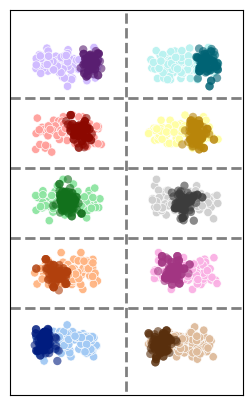

Untrained
Div: tensor(0.1972)


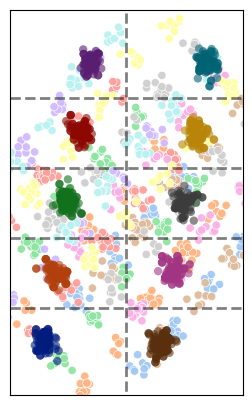

In [56]:
extra_dims = 0 # adds extra noisy dimensions
dupl_rank = 0 # duplicates uniformly sampled extra dimensions from the set of extra_dims-dupl_rank noisy dimensions
zero_rank = 0
mask_dims = 1 # note that you will need to increase this if adding zero_rank or dupl_rank dimensions to the
    # representations. The reason is that it is possible to learn a trivial solution to the CL loss where
    # it only fits to the zero/duplicated dimensions. This will be reflected in the accuracy.
cov_strength = 0 # how much do the extraneous dimensions covary with the x and y values
normalize = False

np.random.seed(12345)
torch.manual_seed(12345)

data_dict = prep_data(
    og_varbs=og_varbs,
    samples=samples,
    v2class=v2class,
    extra_dims=extra_dims,
    dupl_rank=dupl_rank,
    zero_rank=zero_rank,
    mask_dims=mask_dims,
    cov_strength=cov_strength,
    n_samples_per_class=100,
    normalize=normalize
)

mask = data_dict["mask"]
valids = data_dict["valid_intrvs"]
src_vecs = data_dict["src_vecs"][valids]
trg_vecs = data_dict["trg_vecs"][valids]
intrv_idxs = data_dict["intrv_idxs"][valids]
intrv_varbs = data_dict["intrv_varbs"][valids]
intrv_classes = data_dict["intrv_classes"][valids]
src_classes = data_dict["src_classes"][valids]
src_varbs = data_dict["src_varbs"][valids]


d = src_vecs.shape[-1]
mask = torch.zeros(d)
mask[:mask_dims] = 1
empty_mask = torch.zeros_like(mask)
if len(mask)>mask_dims*2:
    empty_mask[mask_dims*2:] = 1

rot_mtx = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(d,d))

with torch.no_grad():
    eye = torch.nn.Linear(d,d)
    eye.weight.data = torch.eye(d).float()
    intrv_vecs = interchange(trg_vecs, src_vecs, eye, mask)
print("Identity")
div = compute_emd(src_vecs, intrv_vecs)
print("Div:", div)
quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, )

with torch.no_grad():
    intrv_vecs = interchange(trg_vecs, src_vecs, rot_mtx, mask)
print("Untrained")
div = compute_emd(src_vecs, intrv_vecs)
print("Div:", div)
quick_plot(src_vecs, intrv_vecs.detach(), src_classes, intrv_classes, )


In [57]:
lr = 0.01
bsize = 200
patience = 100
l2 = 0.005
n_epochs = 1000
drop_p = 0.5
hidden_dim = 128
n_layers = 2 # 1-3 layers 
pre_layernorm = False
layernorm = False
pre_batchnorm = True
batchnorm = True

np.random.seed(12345)
torch.manual_seed(12345)
print("Training Classifier")
classifier, max_acc, _ = train_classifier(
    #normalize_fn(src_vecs),
    src_vecs,
    src_classes,
    lr=lr,
    patience=patience,
    l2=l2,
    hidden_dim=hidden_dim,
    n_epochs=n_epochs,
    drop_p=drop_p,
    bsize=bsize,
    n_layers=n_layers,
    pre_layernorm=pre_layernorm,
    pre_batchnorm=pre_batchnorm,
    layernorm=layernorm,
    batchnorm=batchnorm,
    #model=model,
    ret_best=True,
    verbose=True,
)
classifier.cuda()
classifier.eval()
for p in classifier.parameters():
    p.requires_grad = False

Training Classifier
Sequential(
  (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=2, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=128, out_features=10, bias=True)
)
0 TrnLoss: 1.2128291130065918 ValLoss: 1.3341238498687744 TrnAcc: 0.737500011920929 ValAcc: 0.6899999976158142


/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


50 TrnLoss: 0.08887538313865662 ValLoss: 0.07663129270076752 TrnAcc: 0.9975000023841858 ValAcc: 1.0
100 TrnLoss: 0.08944328129291534 ValLoss: 0.07864699512720108 TrnAcc: 0.9937499761581421 ValAcc: 1.0
150 TrnLoss: 0.093271903693676 ValLoss: 0.06677371263504028 TrnAcc: 0.9937499761581421 ValAcc: 1.0
200 TrnLoss: 0.08849760890007019 ValLoss: 0.06741125136613846 TrnAcc: 0.9975000023841858 ValAcc: 1.0
Converged at epoch 213
213 TrnLoss: 0.13126571476459503 ValLoss: 0.07560033351182938 TrnAcc: 1.0 ValAcc: 1.0


Actn Loss: False
CL Loss: True
Identity


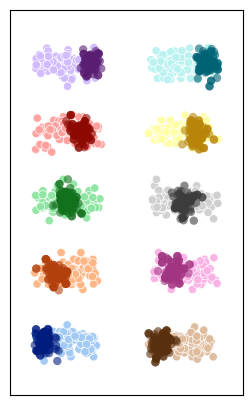

CL Vectors


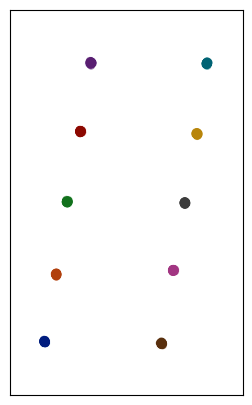

Untrained


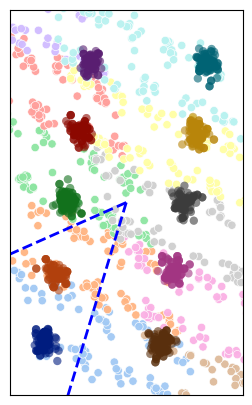

Training Rotation
0 Cl Loss: 1.3892695903778076 ActLoss: 2.484255313873291 Actn: 0.46700000762939453 EMD: 0.9031525254249573 RowEMD 0.9031524658203125


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


50 Cl Loss: 0.053019870072603226 ActLoss: 0.1217300146818161 Actn: 0.9910000562667847 EMD: 0.019237183034420013 RowEMD 0.019237181171774864
100 Cl Loss: 0.0497162863612175 ActLoss: 0.12127816677093506 Actn: 0.9910000562667847 EMD: 0.018088486045598984 RowEMD 0.018088482320308685
150 Cl Loss: 0.045659229159355164 ActLoss: 0.11643621325492859 Actn: 0.9910000562667847 EMD: 0.016696862876415253 RowEMD 0.016696859151124954
200 Cl Loss: 0.041381288319826126 ActLoss: 0.11058715730905533 Actn: 0.9920000433921814 EMD: 0.015265200287103653 RowEMD 0.015265200287103653
250 Cl Loss: 0.03724950551986694 ActLoss: 0.10441015660762787 Actn: 0.9940000176429749 EMD: 0.013889300636947155 RowEMD 0.013889297842979431


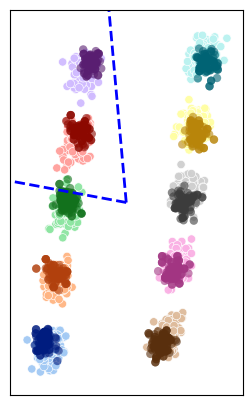

/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


300 Cl Loss: 0.03350988030433655 ActLoss: 0.09840921312570572 Actn: 0.9940000176429749 EMD: 0.012628741562366486 RowEMD 0.012628739699721336
350 Cl Loss: 0.030277162790298462 ActLoss: 0.09301955997943878 Actn: 0.9970000386238098 EMD: 0.011495227925479412 RowEMD 0.011495226062834263
400 Cl Loss: 0.02756420709192753 ActLoss: 0.08842465281486511 Actn: 0.9980000257492065 EMD: 0.010527248494327068 RowEMD 0.010527249425649643
Converged at epoch 400
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
method mean
mtx_type linear
n_epochs 500

CL Vectors


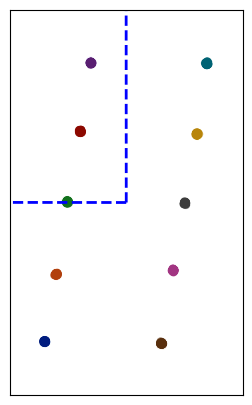

Best Checkpt (by Train Acc)


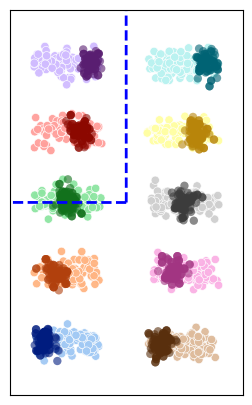

Best Checkpt (by Train Loss)


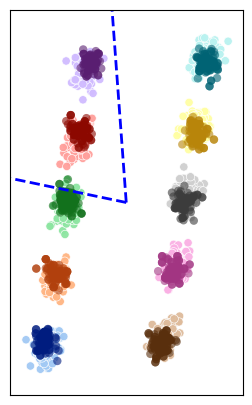

Best Checkpt (by EMD)


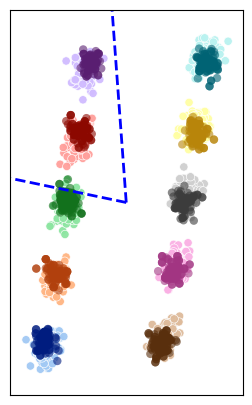

Last Checkpt


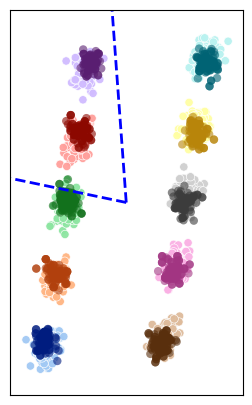

Best (by Acc) -  Cl Loss: 0.11583539098501205 ActLoss: 0.11531677842140198 Actn: 1.0 EMD: 0.05660613998770714 RowEMD: 0.05660613998770714
Best (by EMD) -  Cl Loss: 0.02756420709192753 ActLoss: 0.08842465281486511 Actn: 0.9980000257492065 EMD: 0.010527248494327068 RowEMD: 0.010527249425649643
Last 400 -  Cl Loss: 0.02756420709192753 ActLoss: 0.08842465281486511 Actn: 0.9980000257492065 EMD: 0.010527248494327068 RowEMD 0.010527249425649643


In [58]:
# Run the CL Loss only
lr = 0.01
cl_eps = 100
mask_dims = 1
n_epochs = 500
fig_every = 250
mtx_type = "linear" # "orthog" "linear",
cl_1d = False
rot_dtype = "float"
cl_loss_type = "both"
early_stop_patience = 400
incl_extra = False

d = src_vecs.shape[-1]
mask = torch.zeros(d)
mask[:mask_dims] = 1

np.random.seed(12345)
torch.manual_seed(12345)
ret_dict = train_rotation(
    src_varbs=src_varbs,
    intrv_varbs=intrv_varbs,
    classifier=classifier,
    trg_vecs=trg_vecs,
    src_vecs=src_vecs,
    src_classes=src_classes,
    intrv_classes=intrv_classes,
    mask=mask,
    cl_loss_type = cl_loss_type, #"cos", "mse", "both
    method = "mean",  #"mean" "sample"
    detach_cl_vecs = True,
    shuffle_empty = False,
    incl_extra = incl_extra, # Will include the extraneous subspaces in cl loss if True,
    calc_loss_in_aligned_basis = False,
    cl_1d = cl_1d,
    rot_dtype=rot_dtype,
    lr = lr,
    cl_eps=cl_eps,
    early_stopping=True,
    early_stop_patience=early_stop_patience,
    incl_actn_loss = False,
    incl_cl_loss = True,
    mtx_type = mtx_type, # "orthog" "linear",
    print_every = 50,
    n_epochs = n_epochs,
    fig_every = fig_every,
    save_fig=True,
    incl_dividers=False,
)

Actn Loss: True
CL Loss: False
Identity


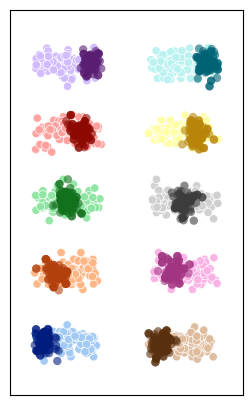

Untrained


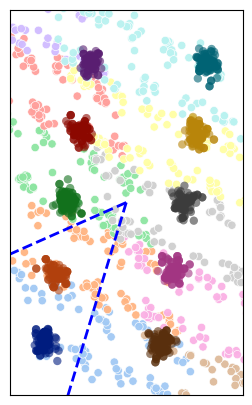

Training Rotation
0 Cl Loss: 1.3892695903778076 ActLoss: 2.484255313873291 Actn: 0.46700000762939453 EMD: 0.9031525254249573 RowEMD 0.9031524658203125


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


50 Cl Loss: 0.06752794235944748 ActLoss: 0.09611386060714722 Actn: 0.9980000257492065 EMD: 0.02766530215740204 RowEMD 0.02766530215740204
100 Cl Loss: 0.0717165395617485 ActLoss: 0.09506087005138397 Actn: 0.999000072479248 EMD: 0.030275965109467506 RowEMD 0.030275966972112656
150 Cl Loss: 0.07158701121807098 ActLoss: 0.09472370892763138 Actn: 0.999000072479248 EMD: 0.030253630131483078 RowEMD 0.03025362826883793
200 Cl Loss: 0.07053296267986298 ActLoss: 0.09432240575551987 Actn: 0.999000072479248 EMD: 0.029685404151678085 RowEMD 0.029685404151678085
250 Cl Loss: 0.0693666934967041 ActLoss: 0.0938517302274704 Actn: 0.999000072479248 EMD: 0.02906431071460247 RowEMD 0.02906430885195732


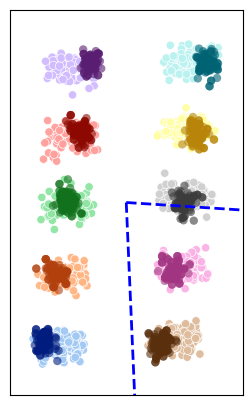

/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


300 Cl Loss: 0.06802347302436829 ActLoss: 0.09331205487251282 Actn: 0.999000072479248 EMD: 0.02835262566804886 RowEMD 0.028352633118629456
350 Cl Loss: 0.06654766947031021 ActLoss: 0.09270410239696503 Actn: 0.999000072479248 EMD: 0.027577942237257957 RowEMD 0.02757793851196766
400 Cl Loss: 0.06492473185062408 ActLoss: 0.09202869981527328 Actn: 0.999000072479248 EMD: 0.026732753962278366 RowEMD 0.026732755824923515
Converged at epoch 400
calc_loss_in_aligned_basis False
cl_eps 100
detach_cl_vecs True
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
method mean
mtx_type linear
n_epochs 500

Best Checkpt (by Train Acc)


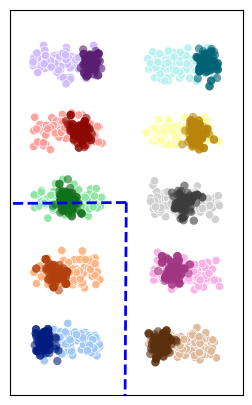

Best Checkpt (by Train Loss)


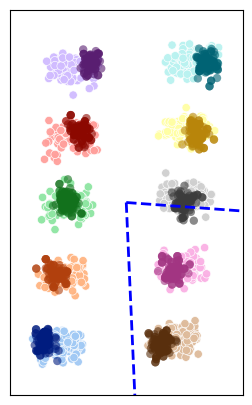

Best Checkpt (by EMD)


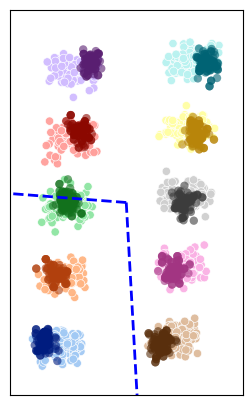

Last Checkpt


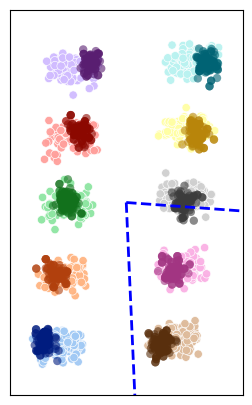

Best (by Acc) -  Cl Loss: 0.12098464369773865 ActLoss: 0.11922802776098251 Actn: 1.0 EMD: 0.059648703783750534 RowEMD: 0.059648703783750534
Best (by EMD) -  Cl Loss: 0.06572722643613815 ActLoss: 0.09670674055814743 Actn: 0.9980000257492065 EMD: 0.026574380695819855 RowEMD: 0.026574376970529556
Last 400 -  Cl Loss: 0.06492473185062408 ActLoss: 0.09202869981527328 Actn: 0.999000072479248 EMD: 0.026732753962278366 RowEMD 0.026732755824923515


In [59]:
# Run the behavioral loss only
np.random.seed(12345)
torch.manual_seed(12345)
ret_dict = train_rotation(
    src_varbs=src_varbs,
    intrv_varbs=intrv_varbs,
    classifier=classifier,
    trg_vecs=trg_vecs,
    src_vecs=src_vecs,
    src_classes=src_classes,
    intrv_classes=intrv_classes,
    mask=mask,
    #cl_loss_type = "both", #"cos", "mse", "both
    method = "mean",  #"mean" "sample"
    calc_loss_in_aligned_basis = False,
    detach_cl_vecs = True,
    shuffle_empty = False,
    incl_extra = False, # Will include the extraneous subspaces in cl loss if True,
    lr = lr,
    cl_eps=cl_eps,
    early_stopping=True,
    early_stop_patience=early_stop_patience,
    incl_actn_loss = True,
    incl_cl_loss = False,
    mtx_type = mtx_type, # "orthog" "linear",
    print_every = 50,
    n_epochs = n_epochs,
    fig_every = fig_every,
    save_fig=True,
    incl_dividers=False,
)


# Multi Tasking

In [60]:
def test_rotation(
        rot_mtx,
        data,
        classifier,
        mask=None,
        incl_extra=False,
        calc_loss_in_aligned_basis=False,
        detach_cl_vecs=False,
        method="mean",
        ylim=[-2.75,1.75],
        fig_save_name=None,
        verbose=False,
        **kwargs,
):
    cl_vecs = get_cl_vectors(
        data["src_varbs"], data["intrv_varbs"], data["src_vecs"], method=method
    )
    if mask is None:
        mask = torch.zeros(src_vecs.shape[-1]).cuda()
        mask[0] = 1

    cl_loss, intrv_vecs = get_cl_loss(
        trg=data["trg_vecs"].cuda(),
        src=data["src_vecs"].cuda(),
        mtx=rot_mtx.cuda(),
        mask=mask.cuda(),
        cl_vecs=cl_vecs.cuda(),
        incl_extra=incl_extra,
        calc_loss_in_aligned_basis=calc_loss_in_aligned_basis,
        detach_cl_vecs=detach_cl_vecs,
    )
    with torch.no_grad():
        src_vecs = data["src_vecs"]
        perm = torch.randperm(len(src_vecs)).long()
        emd = compute_emd(src_vecs[perm].cuda(), intrv_vecs.cuda()).item()
        extra_mask = torch.zeros_like(mask).cuda()
        extra_mask[:2] = 1 # Only using the causal dimensions
        row_emd = compute_emd(
            intrv_vecs.cuda()*extra_mask, src_vecs.cuda()*extra_mask
        ).item()
    actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())

    if verbose:
        print("Cl Loss:", cl_loss.item(), "ActLoss:", actn_loss.item(), "Actn:", acc.item(), "EMD:", emd, "RowEMD:", row_emd)
        quick_plot(
            data["src_vecs"], intrv_vecs.detach(),
            data["src_classes"], data["intrv_classes"],
            ylim=ylim,
            incl_dividers=False,
            save_name=fig_save_name,
        )
    return cl_loss, actn_loss, acc, emd, row_emd

### Task Exploration

In [61]:
import time
from toytask_utils import all_divisions
from datetime import datetime

In [62]:
divisions = all_divisions
divisions

['shared_y',
 'shared_y_overlap',
 'tetris_L',
 'mirror_L',
 'tetris_T',
 'tetris_T_no_overlap',
 'tetris_C',
 'tetris_h',
 'mirror_h',
 'tetris_F',
 'mirror_F',
 'random',
 'random_overlap',
 'inner_square',
 'xor',
 'distinct_xy_overlap',
 'distinct_xy',
 'distinct_y_overlap',
 'distinct_y']

In [63]:
divisions = ["inner_square"]

In [75]:
csv_id = datetime.now().strftime('%m-%d-%Y_%HH%MM')
print(csv_id)

data_params = {
    "extra_dims": 16,
    "dupl_rank": 0, # duplicates extra dims
    "zero_rank": 0, # zeros out extra dims in a rotated space
    "cov_strength": 0, # how much do the extraneous dimensions covary with the x and y values,
    "n_samples_per_class": 100,
    "mask_dims": 1,
}

mlp_params = {
    "lr": 0.01,
    "patience": 100,
    "l2": 0.005,
    "bsize": 200,
    "n_epochs": 1000,
    "drop_p": 0.5,
    "hidden_dim": 128,
    "n_layers": 2, # 1-3 layers
    "pre_batchnorm": True,
    "batchnorm": True,
    "ret_best": True,
    "epoch_prog": True,
}


mtx_types = ["linear",] # "linear"]
cl_epses = [100]
n_repeats = 5
do_normalize = False
use_best_for_actns = "by_acc"
use_best_for_cls =   "by_emd"
actn_losses = [False, True]
verbose = False

ylim = [-2.75, 2.75]

exp_params = {
    "n_epochs": 3000,
    "lr": 0.01,
    "cl_eps": 100,
    "shuffle_empty": False,
    "method": "mean",
    "incl_extra": False,
    "calc_loss_in_aligned_basis": False,
    "detach_cl_vecs": True,
    "cl_1d": True,
    "mtx_type": "orthog",
    "cl_loss_type": "both",
    "early_stop_patience": 400,
    "rot_dtype": "float", # double or float
}
excl_divisions = {
    "random",
    "random_overlap",
}

dfs = []
all_keys = {*set(data_params.keys()), *set(mlp_params.keys()), *set(exp_params.keys())}
save_keys = ["seed", "incl_extra", "extra_dims", "lr", "incl_actn_loss", "incl_cl_loss", "cl_eps", "mask_dims", "cl_1d"]
excl_keys = [key for key in all_keys if key not in save_keys]
classifier_dict = dict() # used to store trained classifiers
for repeat in range(n_repeats):
    seed = int(str(repeat+1)*5)
    for cl_eps in cl_epses:
        exp_params["cl_eps"] = cl_eps
        for ial,incl_actn_loss in enumerate(actn_losses):
            for icl,incl_cl_loss in enumerate([False, True,]):
                if not incl_actn_loss and not incl_cl_loss: continue
                d = data_params["extra_dims"]+2
                df_dict = {
                    "run_id": [],
                    "seed": [],
                    "task_num": [],
                    "task_division": [],
                    "n_samples": [],
                    "min_class_count": [],
                    "max_class_count": [],
                    "mean_class_count": [],
                    "class_trn_acc": [],
                    "class_val_acc": [],
                    "cl_loss": [],
                    "actn_loss": [],
                    "actn_acc": [],
                    "emd": [],
                    "row_emd": [],
                    "cross_cl_loss": [],
                    "cross_actn_loss": [],
                    "cross_actn_acc": [],
                    "cross_emd": [],
                    "cross_row_emd": [],
                    "mtx_type": [],
                }

                exp_params["incl_cl_loss"] = incl_cl_loss
                exp_params["incl_actn_loss"] = incl_actn_loss

                for tdi,task_division in enumerate(divisions):
                    if task_division in excl_divisions:
                        print("Skipping", task_division)
                        continue
                    print("Starting Task Division", task_division)

                    np.random.seed(seed)
                    torch.manual_seed(seed)

                    for _ in mtx_types:
                        df_dict["task_division"].append(task_division)
                        df_dict["task_division"].append(task_division)
                        df_dict["task_num"].append(0)
                        df_dict["task_num"].append(1)
                    task1_bools, task2_bools = make_tasks(task_division=task_division, varbs=og_varbs)

                    ##########################################################################
                    ### DATA PREP
                    ##########################################################################
                    data_dict = prep_data(
                        og_varbs=og_varbs[task1_bools],
                        samples=samples[task1_bools],
                        **data_params,
                    )

                    valids = data_dict["valid_intrvs"]
                    if valids.sum() == 0:
                        print("No valid intrvs")
                        continue
                    src = data_dict["src_vecs"][valids]
                    trg = data_dict["trg_vecs"][valids]
                    if do_normalize:
                        src = normalize_fn(src)
                        trg = normalize_fn(trg)
                    task1_data = {
                        "src_vecs": src,
                        "trg_vecs": trg,
                        "intrv_varbs": data_dict["intrv_varbs"][valids],
                        "intrv_classes": data_dict["intrv_classes"][valids],
                        "src_varbs": data_dict["src_varbs"][valids],
                        "src_classes": data_dict["src_classes"][valids],
                    }
                    counts = []
                    intrv_classes = data_dict["intrv_classes"]
                    for c in sorted(set(intrv_classes.cpu().tolist())):
                        counts.append((intrv_classes==c).long().sum().item())
                    for _ in mtx_types:
                        df_dict["n_samples"].append(len(intrv_classes))
                        df_dict["min_class_count"].append(np.min(counts))
                        df_dict["max_class_count"].append(np.max(counts))
                        df_dict["mean_class_count"].append(np.mean(counts))
                    print("Class Distr 1:",
                          "\n\tMin:", df_dict["min_class_count"][-1],
                          "\n\tMax:", df_dict["max_class_count"][-1],
                          "\n\tMean:", df_dict["mean_class_count"][-1],
                        )

                    data_dict = prep_data(
                        og_varbs=og_varbs[task2_bools],
                        samples=samples[task2_bools],
                        **data_params,
                    )

                    valids = data_dict["valid_intrvs"]
                    src = data_dict["src_vecs"][valids]
                    trg = data_dict["trg_vecs"][valids]
                    if do_normalize:
                        src = normalize_fn(src)
                        trg = normalize_fn(trg)
                    task2_data = {
                        "src_vecs": src,
                        "trg_vecs": trg,
                        "intrv_varbs": data_dict["intrv_varbs"][valids],
                        "intrv_classes": data_dict["intrv_classes"][valids],
                        "src_varbs": data_dict["src_varbs"][valids],
                        "src_classes": data_dict["src_classes"][valids],
                    }
                    counts = []
                    intrv_classes = data_dict["intrv_classes"]
                    for c in sorted(set(intrv_classes.cpu().tolist())):
                        counts.append((intrv_classes==c).long().sum().item())
                    for _ in mtx_types:
                        df_dict["n_samples"].append(len(intrv_classes))
                        df_dict["min_class_count"].append(np.min(counts))
                        df_dict["max_class_count"].append(np.max(counts))
                        df_dict["mean_class_count"].append(np.mean(counts))
                    print("Class Distr 2:",
                          "\n\tMin:", df_dict["min_class_count"][-1],
                          "\n\tMax:", df_dict["max_class_count"][-1],
                          "\n\tMean:", df_dict["mean_class_count"][-1],
                        )

                    if verbose:
                        print(task_division)
                        quick_plot(
                            task1_data["src_vecs"], task2_data["src_vecs"],
                            incl_legend=True,
                            labels=["Task1", "Task2"],
                            incl_dividers=False,
                            ylim=ylim,
                        )

                    ##########################################################################
                    data_id = "_".join([f"{k}{v}" for k,v in data_params.items()])
                    mlp_id = "_".join([f"{k}{v}" for k,v in mlp_params.items()])
                    ##########################################################################
                    ### Classifier Training
                    ##########################################################################
                    if verbose:
                        print()
                        print("Task Data:", len(task1_data["src_vecs"]))
                        print("\t", len(task1_data["src_classes"]))
                        print("mlp_params:", mlp_params)
                        print()
                    print("Training Classifier1")
                    train_id = data_id + "_" + mlp_id + f"seed{seed}_{task_division}1"
                    if train_id in classifier_dict:
                        classifier1, trn_acc, val_acc = classifier_dict[train_id]
                    else:
                        classifier1, trn_acc, val_acc = train_classifier(
                            task1_data["src_vecs"],
                            task1_data["src_classes"],
                            **mlp_params,
                            verbose=verbose,
                        )
                        classifier_dict[train_id] = (classifier1, trn_acc, val_acc)
                    classifier1.cuda()
                    classifier1.eval()
                    for p in classifier1.parameters():
                        p.requires_grad = False
                    for _ in mtx_types:
                        df_dict["class_trn_acc"].append(trn_acc)
                        df_dict["class_val_acc"].append(val_acc)

                    print("Training Classifier2")
                    train_id = data_id + "_" + mlp_id + f"seed{seed}_{task_division}2"
                    if train_id in classifier_dict:
                        classifier2, trn_acc, val_acc = classifier_dict[train_id]
                    else:
                        classifier2, trn_acc, val_acc = train_classifier(
                            task2_data["src_vecs"],
                            task2_data["src_classes"],
                            **mlp_params,
                            verbose=verbose,
                        )
                        classifier_dict[train_id] = (classifier2, trn_acc, val_acc)
                    classifier2.cuda()
                    classifier2.eval()
                    for p in classifier2.parameters():
                        p.requires_grad = False
                    for _ in mtx_types:
                        df_dict["class_trn_acc"].append(trn_acc)
                        df_dict["class_val_acc"].append(val_acc)

                    mask = data_dict["mask"]

                    ##########################################################################
                    ### Rotation Matrix Training
                    ##########################################################################
                    for mtx_type in mtx_types:
                        print("--------------------")
                        print("Performing New Training")
                        if verbose:
                            for k in sorted(save_keys):
                                if k in exp_params: v = exp_params[k]
                                elif k in data_params: v = data_params[k]
                                elif k in mlp_params: v = mlp_params[k]
                                print(k,v)
                            print()

                        important_keys = ["cl_loss", "actn_loss", "acc", "emd", "row_emd"]

                        exp_params["mtx_type"] = mtx_type
                        run_id = time.time()
                        df_dict["run_id"].append(run_id)
                        df_dict["run_id"].append(run_id)
                        df_dict["seed"].append(seed)
                        df_dict["seed"].append(seed)
                        df_dict["mtx_type"].append(mtx_type)
                        df_dict["mtx_type"].append(mtx_type)
                        print("Training Task1 Matrix", mtx_type)
                        ret_dict1 = train_rotation(
                            **task1_data,
                            classifier=classifier1,
                            mask=mask,
                            **exp_params,
                            print_every=200,
                            fig_every=np.inf,
                            early_stopping=True,
                            verbose=verbose,
                        )
                        rd = ret_dict1
                        best_dict = rd["best_metrics"]
                        rm = rd["last_mtx"]
                        if incl_cl_loss:
                            if use_best_for_cls=="by_acc":
                                rm = best_dict["mtx"]
                            elif use_best_for_cls=="by_loss":
                                rm = rd["bestloss_metrics"]["mtx"]
                                best_dict = rd["bestloss_metrics"]
                            elif use_best_for_cls=="by_emd":
                                rm = rd["bestemd_metrics"]["mtx"]
                                best_dict = rd["bestemd_metrics"]
                        else:
                            if use_best_for_actns=="by_acc":
                                rm = best_dict["mtx"]
                            elif use_best_for_actns=="by_loss":
                                rm = rd["bestloss_metrics"]["mtx"]
                                best_dict = rd["bestloss_metrics"]
                            elif use_best_for_actns=="by_emd":
                                rm = rd["bestemd_metrics"]["mtx"]
                                best_dict = rd["bestemd_metrics"]
                        task1_rot_mtx = rm
                        cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                        print("End Task1 Training")
                        print()
                        df_dict["cl_loss"].append(float(cl_loss))
                        df_dict["actn_loss"].append(float(actn_loss))
                        df_dict["actn_acc"].append(float(acc))
                        df_dict["emd"].append(float(emd))
                        df_dict["row_emd"].append(float(row_emd))


                        print("Training Task2 Matrix")
                        ret_dict2 = train_rotation(
                            **task2_data,
                            classifier=classifier2,
                            mask=mask,
                            **exp_params,
                            print_every=200,
                            fig_every=np.inf,
                            early_stopping=True,
                            verbose=verbose,
                        )
                        rd = ret_dict2
                        best_dict = rd["best_metrics"]
                        rm = rd["last_mtx"]
                        if incl_cl_loss:
                            if use_best_for_cls=="by_acc":
                                rm = best_dict["mtx"]
                            elif use_best_for_cls=="by_loss":
                                rm = rd["bestloss_metrics"]["mtx"]
                                best_dict = rd["bestloss_metrics"]
                            elif use_best_for_cls=="by_emd":
                                rm = rd["bestemd_metrics"]["mtx"]
                                best_dict = rd["bestemd_metrics"]
                        else:
                            if use_best_for_actns=="by_acc":
                                rm = best_dict["mtx"]
                            elif use_best_for_actns=="by_loss":
                                rm = rd["bestloss_metrics"]["mtx"]
                                best_dict = rd["bestloss_metrics"]
                            elif use_best_for_actns=="by_emd":
                                rm = rd["bestemd_metrics"]["mtx"]
                                best_dict = rd["bestemd_metrics"]
                        task2_rot_mtx = rm
                        cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                        print("End Task2 Training")
                        print()
                        df_dict["cl_loss"].append(float(cl_loss))
                        df_dict["actn_loss"].append(float(actn_loss))
                        df_dict["actn_acc"].append(float(acc))
                        df_dict["emd"].append(float(emd))
                        df_dict["row_emd"].append(float(row_emd))


                        ##########################################################################
                        ### Testing
                        ##########################################################################
                        save_params = {**data_params, **exp_params}
                        for k in list(save_params.keys()):
                            if k in excl_keys: del save_params[k]
                        save_params["task"] = 1
                        save_name = os.path.join("figs/",get_plot_save_name(save_params))
                        print("Testing Task1 Matrix on Task1 Data")
                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                            task1_rot_mtx,
                            task1_data,
                            classifier=classifier1,
                            mask=mask,
                            **exp_params,
                            ylim=ylim,
                            #fig_save_name=save_name,
                            verbose=verbose,
                        )
                        print("Testing Task1 Matrix on Task2 Data")
                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                            task1_rot_mtx,
                            task2_data,
                            classifier=classifier2,
                            mask=mask,
                            **exp_params,
                            ylim=ylim,
                            #fig_save_name=save_name,
                            verbose=verbose,
                        )
                        df_dict["cross_cl_loss"].append(float(cl_loss))
                        df_dict["cross_actn_loss"].append(float(actn_loss))
                        df_dict["cross_actn_acc"].append(float(acc))
                        df_dict["cross_emd"].append(float(emd))
                        df_dict["cross_row_emd"].append(float(row_emd))

                        print("Testing Task2 Matrix on Task2 Data")
                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                            task2_rot_mtx,
                            task2_data,
                            classifier=classifier2,
                            mask=mask,
                            **exp_params,
                            ylim=ylim,
                            #fig_save_name=save_name,
                            verbose=verbose,
                        )
                        print("Testing Task2 Matrix on Task1 Data")
                        save_params["task"] = 2
                        save_name = os.path.join("figs/",get_plot_save_name(save_params))
                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                            task2_rot_mtx,
                            task1_data,
                            classifier=classifier1,
                            mask=mask,
                            **exp_params,
                            ylim=ylim,
                            #fig_save_name=save_name,
                            verbose=verbose,
                        )
                        df_dict["cross_cl_loss"].append(float(cl_loss))
                        df_dict["cross_actn_loss"].append(float(actn_loss))
                        df_dict["cross_actn_acc"].append(float(acc))
                        df_dict["cross_emd"].append(float(emd))
                        df_dict["cross_row_emd"].append(float(row_emd))

                        classifier1.cpu()
                        classifier2.cpu()
                        print("-"*100)
                        print()
                        print()
                        print()
                        print()
                        print()
                df = pd.DataFrame(df_dict)
                for k in exp_params:
                    if k!="mtx_type":
                        df[k] = exp_params[k]
                for k in data_params:
                    df[k] = data_params[k]
                dfs.append(df)
            full_df = pd.concat(dfs)
            full_df.to_csv(f"csvs/task_ablations_{csv_id}.csv", header=True, index=False)

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


11-18-2025_00H02M
Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1


 21%|█████████████████████████████▌                                                                                                                | 208/1000 [00:04<00:17, 44.08it/s]


Converged at epoch 208
208 TrnLoss: 0.10263070464134216 ValLoss: 0.15320782363414764 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 20%|████████████████████████████▉                                                                                                                 | 204/1000 [00:04<00:18, 42.79it/s]
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 204
204 TrnLoss: 0.08640173077583313 ValLoss: 0.13215075433254242 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it

Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1


 21%|█████████████████████████████▍                                                                                                                | 207/1000 [00:05<00:21, 37.49it/s]


Converged at epoch 207
207 TrnLoss: 0.06549549847841263 ValLoss: 0.06784845888614655 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 21%|█████████████████████████████▊                                                                                                                | 210/1000 [00:05<00:19, 40.57it/s]


Converged at epoch 210
210 TrnLoss: 0.044560402631759644 ValLoss: 0.06045784428715706 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1


 19%|███████████████████████████▍                                                                                                                  | 193/1000 [00:05<00:21, 37.85it/s]


Converged at epoch 193
193 TrnLoss: 0.10503362864255905 ValLoss: 0.1731680929660797 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 20%|████████████████████████████▎                                                                                                                 | 199/1000 [00:04<00:20, 39.89it/s]


Converged at epoch 199
199 TrnLoss: 0.031251631677150726 ValLoss: 0.04372166842222214 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Training Classifier2


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1


 21%|██████████████████████████████▍                                                                                                               | 214/1000 [00:05<00:19, 40.13it/s]


Converged at epoch 214
214 TrnLoss: 0.0814862921833992 ValLoss: 0.08342479914426804 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 21%|█████████████████████████████▍                                                                                                                | 207/1000 [00:04<00:17, 45.35it/s]


Converged at epoch 207
207 TrnLoss: 0.0732913613319397 ValLoss: 0.09134599566459656 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Training Classifier2


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())
/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it

Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1


 22%|██████████████████████████████▌                                                                                                               | 215/1000 [00:04<00:17, 44.40it/s]


Converged at epoch 215
215 TrnLoss: 0.05378662049770355 ValLoss: 0.0738687738776207 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 21%|█████████████████████████████▌                                                                                                                | 208/1000 [00:04<00:18, 43.53it/s]


Converged at epoch 208
208 TrnLoss: 0.05686087906360626 ValLoss: 0.11448995023965836 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Classifier2
--------------------
Performing New Training
Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task1 Data
Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------







In [76]:
if csv_id is None:
    csv_ids = []
    for f in os.listdir("csvs"):
        if "task_ablations_" in f:
            csv_ids.append(f.split("task_ablations_")[-1].split(".")[0])
    csv_ids = sorted(csv_ids)
    print("Need to pick csv id:")
    for i,csv in enumerate(csv_ids):
        print(i, csv)
else:
    full_df = pd.read_csv(f"csvs/task_ablations_{csv_id}.csv")
    full_df


In [77]:
from datetime import datetime
now = datetime.now().strftime('%m-%d-%Y_%HH%MM')
print(now)

11-18-2025_00H24M


In [78]:
full_df.loc[full_df["class_val_acc"]<0.95] # look at cases where the classifier was bad

,run_id,seed,task_num,task_division,n_samples,min_class_count,max_class_count,mean_class_count,class_trn_acc,class_val_acc,cl_loss,actn_loss,actn_acc,emd,row_emd,cross_cl_loss,cross_actn_loss,cross_actn_acc,cross_emd,cross_row_emd,mtx_type,n_epochs,lr,cl_eps,shuffle_empty,method,incl_extra,calc_loss_in_aligned_basis,detach_cl_vecs,cl_1d,cl_loss_type,early_stop_patience,rot_dtype,incl_cl_loss,incl_actn_loss,extra_dims,dupl_rank,zero_rank,cov_strength,n_samples_per_class,mask_dims


In [79]:
CL = "CL"
CLDAS = "DAS+\nCL"
DAS = "DAS"
loss_map = {
    (False,True): CL,
    (True,True): CLDAS,
    (True,False): DAS,
}
full_df["loss_type"] = full_df.apply(lambda x: loss_map[(x.incl_actn_loss, x.incl_cl_loss)], axis=1)

In [80]:
sort_map = {
    "Original": 0,
    "Dense": 1,
    "Sparse": 2,
}
full_df["train_type"] = full_df.apply(
    lambda x: f"{x.mtx_type}{x.incl_cl_loss*'_cl'}{x.incl_actn_loss*'_actn'}_{x.cl_eps}",
    axis=1)
full_df["task_spacing"] = "Original"
full_df.loc[(full_df["task_num"]==0)&(full_df["task_division"]=="inner_square"), "task_spacing"] = "Sparse"
full_df.loc[(full_df["task_num"]==1)&(full_df["task_division"]=="inner_square"), "task_spacing"] = "Dense"
full_df["spacing_order"] = full_df.apply(lambda x: sort_map[x.task_spacing], axis=1)
full_df.loc[~full_df["incl_cl_loss"]&full_df["incl_actn_loss"], "cl_eps"] = 0

In [81]:
color_order = [
    #-3,0,4,4,6,3,2,0,6,7,-1
    2,-1,-3,4,4,6,3,2,0,6,7,-1
]

In [82]:
full_df["extra_dims"].unique()

array([16])

Starting Task inner_square
Behavior Only Accuracy {'Dense': np.float64(0.9485000014305115), 'Sparse': np.float64(0.9274999976158143)} +/- {'Dense': np.float64(0.020805649056528326), 'Sparse': np.float64(0.019685021350387005)}
Behavior Only EMD {'Dense': np.float64(0.16043284237384794), 'Sparse': np.float64(0.17734797894954674)} +/- {'Dense': np.float64(0.0643300940739344), 'Sparse': np.float64(0.03883938457504284)}
inner_square


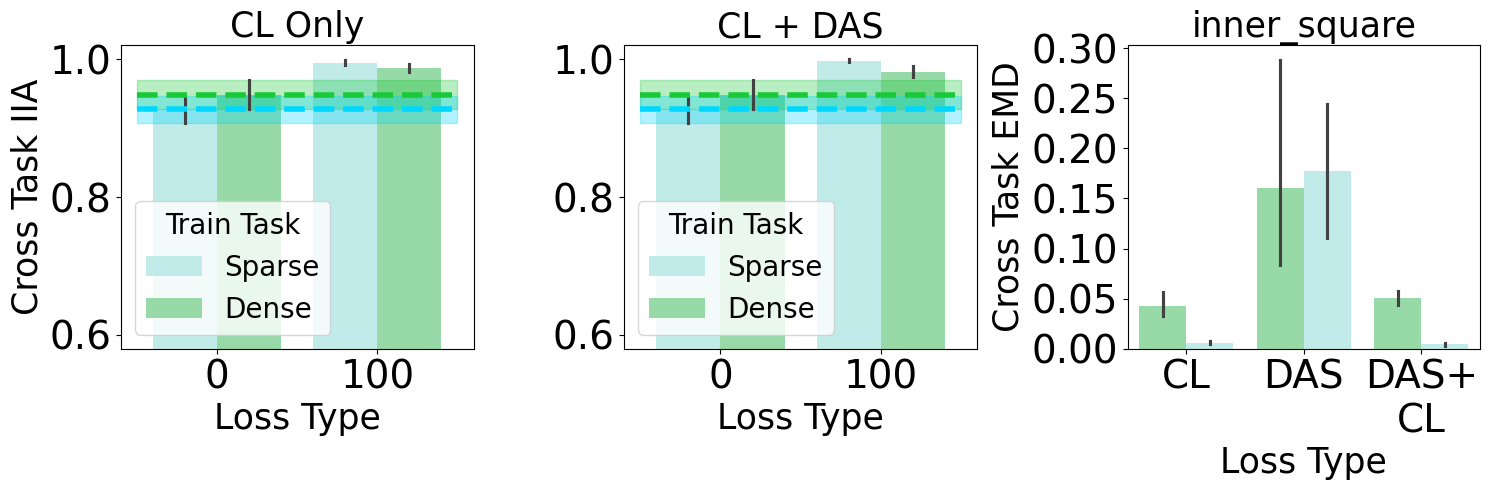

In [83]:
# Pick cases you want to plot
incl_filters = {
    #"mtx_type": ["orthog"],
    #"extra_dims": [64], # 16,],
    "incl_extra": [False],
    #"prop_rank": [1,],
    #"cov_strength": [0], #,1,], # how much do the extraneous dimensions covary with the x and y values,
    "mask_dims": [1,],
    #"lr": [0.05],
    #"cl_eps": [50],
    #"task_spacing": ["Sparse"],
    #"task_division": ["inner_square"],
}
excl_filters = {
    #"task_division": excl_divisions,
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0.95 # Ensures we're only looking at cases where classifiers were successful

rot = 35
ylim = [0.58,1.02]
x = "loss_type"
y = "cross_actn_acc"
hue = "task_spacing"
leg_title = "Train Task" # " ".join([h.capitalize() for h in hue.split("_")])
labelsize = 25
ticksize = 28
fontsize = 30
titlesize = 25
legendsize = 20
linewidth = 4
err_alpha = 0.3
yticks = [0.6, 0.8, 1.0]


if hue=="task_spacing":
    p = {
        "Dense": sns.color_palette("pastel")[color_order[0]],
        "Sparse": sns.color_palette("pastel")[color_order[1]],
    }
    pp = {
        "Dense": sns.color_palette("bright")[color_order[0]],
        "Sparse": sns.color_palette("bright")[color_order[1]],
    }
else:
    p = {k: sns.color_palette("pastel")[color_order[i]] for i,k in enumerate(plot_df[hue].unique())}
    pp = {k: sns.color_palette("bright")[color_order[i]] for i,k in enumerate(plot_df[hue].unique())}
sort_map = {0:0,1:1}
for task in set(full_df["task_division"]):
    print("Starting Task", task)
    plot_df = full_df.copy()
    plot_df = plot_df.loc[plot_df["class_val_acc"]>class_acc_threshold]
    for filt,vals in incl_filters.items():
        plot_df = plot_df.loc[plot_df[filt].isin(vals)]
    for filt,vals in excl_filters.items():
        plot_df = plot_df.loc[~plot_df[filt].isin(vals)]
    plot_df = plot_df.loc[plot_df["task_division"]==task]
    plot_df = plot_df.copy()
    if len(plot_df)<=0:
        print("No samples for task", task)
        continue
    
    #combo_df = plot_df.loc[plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]].copy()
    #combo_df["cl_eps"] = 0
    #combo_df["incl_cl_loss"] = True
    #cl_df = combo_df.copy()
    #cl_df["incl_actn_loss"] = False
    #plot_df = pd.concat([ plot_df, combo_df, cl_df, ])
    
    bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
    plot_df.loc[bools,"cl_eps"] = 0
    
    # Pick out best CL epsilon
    group_cols = [
        "seed", "incl_extra", "extra_dims",
        "lr",  "mask_dims", "cl_1d", "loss_type",
        "cl_eps",
    ]
    dupl_cols = [gc for gc in group_cols if gc!="cl_eps"] + ["task_spacing",]
    plot_df["group_acc"] = plot_df.groupby(group_cols)["cross_actn_acc"].transform("mean")
    plot_df["group_emd"] = plot_df.groupby(group_cols)["cross_row_emd"].transform("mean")
    plot_df = plot_df.sort_values(by=["group_acc", "group_emd"], ascending=[False,True])\
        .drop_duplicates(dupl_cols)
    
    # Determine accuracy in absence of cl loss
    bloss_acc = dict(plot_df.loc[bools].groupby(hue)[y].mean())
    bloss_err = dict(plot_df.loc[bools].groupby(hue)[y].sem())
    bloss_emd = dict(plot_df.loc[bools].groupby(hue)["cross_row_emd"].mean())
    bloss_emr = dict(plot_df.loc[bools].groupby(hue)["cross_row_emd"].sem())
    print("Behavior Only Accuracy", bloss_acc, "+/-", bloss_err)
    print("Behavior Only EMD", bloss_emd, "+/-", bloss_emr)
    
    fig,axes = plt.subplots(1,2,figsize=(8,5))
    
    print(task)
    ax = axes[0]
    plt.sca(ax)
    temp_df = plot_df.loc[plot_df["loss_type"].isin({CL,CLDAS})]
    sns.barplot(x=x, y=y, hue=hue, data=temp_df, ax=ax, palette=p, errorbar="se")
    plt.title(f"", fontsize=titlesize)
    plt.ylim(ylim)
    plt.xlabel("", fontsize=labelsize)
    plt.ylabel("Cross Task IIA", fontsize=labelsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(yticks,fontsize=ticksize)
    
    # Baseline
    xs = list(range(len(set(temp_df[x]))))
    xs = [np.min(xs)-0.5] + xs + [np.max(xs)+0.5]
    xs = np.asarray(xs)
    for i,k in enumerate(bloss_acc):
        acc = bloss_acc[k]
        err = bloss_err[k]
        color = pp[k]
        ys = np.asarray([acc for _ in xs])
        plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
        plt.fill_between(xs, ys-err, ys+err, alpha=err_alpha, color=color, )
        
    plt.legend(loc="lower left", title=leg_title, fontsize=legendsize, title_fontsize=legendsize)
    
    # EMD
    ax = axes[1]
    plt.sca(ax)
    #temp_df = plot_df.copy()
    temp_df = plot_df.loc[plot_df["loss_type"].isin({CL,CLDAS})]
    sns.barplot(x="loss_type", y="cross_row_emd", hue=hue, data=temp_df, ax=ax, palette=p)
    plt.title(f"", fontsize=titlesize)
    plt.xlabel("", fontsize=labelsize)
    plt.ylabel("Cross Task EMD", fontsize=labelsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    
    # Baseline
    xs = list(range(len(set(temp_df[x]))))
    xs = [np.min(xs)-0.5] + xs + [np.max(xs)+0.5]
    xs = np.asarray(xs)
    for i,k in enumerate(bloss_emd):
        acc = bloss_emd[k]
        err = bloss_emr[k]
        color = pp[k]
        ys = np.asarray([acc for _ in xs])
        plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
        plt.fill_between(xs, ys-err, ys+err, alpha=err_alpha, color=color, )
    
    plt.legend(loc="lower left", title=leg_title, fontsize=legendsize, title_fontsize=legendsize).set_visible(False)
    
    plt.tight_layout()
    #plt.savefig(f"figs/ood_inner_square_{extra_dims}d.png", dpi=600, bbox_inches="tight")
    plt.show()

In [84]:
incl_filters = {
    "incl_extra": [False], # refers to whether the CL loss is applied to only the masked dimensions or all dimensions
    #"extra_dims": [64], # 16,],
    "mask_dims": [1,],
    #"lr": [0.01],
    #"cl_eps": [50],
    #"task_spacing": ["Sparse"],
    "task_division": ["inner_square"],
}
excl_filters = {
    #"task_division": excl_divisions,
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0 # filters out MLPs that failed to solve the classification task

groups = ["loss_type",]
metrics = ["emd", "row_emd", "cross_emd", "cross_row_emd", "actn_acc", "cross_actn_acc",]
mtx_type = "orthog"

plot_df = full_df.copy()
plot_df = plot_df.loc[(plot_df["class_val_acc"]>class_acc_threshold)]
for filt,vals in incl_filters.items():
    plot_df = plot_df.loc[plot_df[filt].isin(vals)]
for filt,vals in excl_filters.items():
    plot_df = plot_df.loc[~plot_df[filt].isin(vals)]
plot_df = plot_df.copy()

temp = plot_df.groupby(groups)[metrics]\
    .agg(["mean", "sem"]).reset_index()
columns = []
for col in temp.columns:
    if type(col)==tuple:
        columns.append(f"{col[0]} {col[1]}".replace(" mean", "").strip())
    else:
        columns.append(col.strip())
temp.columns = columns
#temp.sort_values(by=["spacing_order", "cl_eps"], ascending=False)
temp.sort_values(by=["loss_type"])

,loss_type,emd,emd sem,row_emd,row_emd sem,cross_emd,cross_emd sem,cross_row_emd,cross_row_emd sem,actn_acc,actn_acc sem,cross_actn_acc,cross_actn_acc sem
0,CL,4.012785,0.096032,0.008918,0.001628,4.031002,0.098360,0.024417,0.006988,0.9980,0.000816,0.99125,0.003318
1,DAS,6.460943,0.704046,0.147057,0.034241,6.203514,0.521197,0.168890,0.035536,0.9995,0.000333,0.93800,0.013948
2,DAS+\nCL,4.024758,0.095847,0.008170,0.001611,4.043244,0.098784,0.027485,0.007995,0.9990,0.000553,0.98975,0.004765


In [85]:
from scipy import stats

def regress(x,y):
    m = stats.linregress(x.squeeze(),y)
    return m.slope, m.intercept, m.pvalue, m.rvalue**2
x = np.random.randn(100)
f = lambda x: 2*x+1
y = f(x)
regress(x,y)

(np.float64(2.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

In [86]:
# Pick cases you want to plot
incl_filters = {
    # "extra_dims": [64], # 16,],
    "incl_extra": [False],
    "mask_dims": [1,],
    "task_division": ["inner_square"],
}
excl_filters = {
    #"task_division": excl_divisions,
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0

x_axis = "mask_dims"
hue = "loss_type"
col = "lr"
row = "extra_dims"


plot_df = full_df.copy()
plot_df = plot_df.loc[plot_df["class_val_acc"]>class_acc_threshold]
for filt,vals in incl_filters.items():
    plot_df = plot_df.loc[plot_df[filt].isin(vals)]
for filt,vals in excl_filters.items():
    plot_df = plot_df.loc[~plot_df[filt].isin(vals)]

bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
plot_df.loc[bools,"cl_eps"] = 0

lin_regs = {
    x_axis: [],
    hue: [],
    col: [],
    row: [],
    "emd_type": [],
    "coef": [],
    "intercept": [],
    "pvalue": [],
    "rvalue": [],
}
params = []
pvals = []

temp_df = plot_df.copy()
for xx in set(temp_df[x_axis]):
    ttemp = temp_df.loc[temp_df[x_axis]==xx]
    for hhue in set(ttemp[hue]):
        tttemp = ttemp.loc[ttemp[hue]==hhue]
        if len(tttemp)==0: continue
        for c in set(tttemp[col]):
            tttt = tttemp.loc[tttemp[col]==c]
            if len(tttt)==0: continue
            for r in set(tttt[row]):
                t = tttt.loc[tttt[row]==r]
                if len(t)==0: continue
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["cross_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("cross")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("within")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["cross_row_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("row_cross")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["row_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("row_within")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
df = pd.DataFrame(lin_regs)
df

,mask_dims,loss_type,lr,extra_dims,emd_type,coef,intercept,pvalue,rvalue


In [87]:
for emd_type in ["cross_emd", "emd", "cross_row_emd", "row_emd"]:
    coef,intercept,pvalue,rvalue = regress(np.asarray(plot_df[emd_type])[:,None], np.asarray(plot_df["cross_actn_acc"]))
    print("EMD Type:", emd_type)
    print("\tCoef:", coef)
    print("\tIntrc:", intercept)
    print("\tpvalue:", pvalue)
    print("\trvalue:", rvalue)

EMD Type: cross_emd
	Coef: nan
	Intrc: nan
	pvalue: nan
	rvalue: nan
EMD Type: emd
	Coef: nan
	Intrc: nan
	pvalue: nan
	rvalue: nan
EMD Type: cross_row_emd
	Coef: nan
	Intrc: nan
	pvalue: nan
	rvalue: nan
EMD Type: row_emd
	Coef: nan
	Intrc: nan
	pvalue: nan
	rvalue: nan


/tmp/ipykernel_203430/1764090119.py:4: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  m = stats.linregress(x.squeeze(),y)


## Hyperparameter Search

In [ ]:
import time
from toytask_utils import all_divisions
from datetime import datetime

csv_id = datetime.now().strftime('%m-%d-%Y_%HH%MM')
print(csv_id)


data_params = {
    "extra_dims": 128,
    "dupl_rank": 0, # duplicates extra dims
    "zero_rank": 0, # zeros out extra dims in a rotated space
    "cov_strength": 0, # how much do the extraneous dimensions covary with the x and y values,
    "n_samples_per_class": 100,
    "mask_dims": 1,
}

mlp_params = {
    "lr": 0.01,
    "patience": 100,
    "l2": 0.005,
    "bsize": 200,
    "patience": 100,
    "n_epochs": 1000,
    "drop_p": 0.5,
    "hidden_dim": 128,
    "n_layers": 2, # 1-3 layers
    "pre_batchnorm": True,
    "batchnorm": True,
    "ret_best": True,
    "epoch_prog": True,
}


divisions = [ "inner_square", "original" ]
mtx_types = ["linear",] # "orthogonal"]
cl_epses = [1, 10, 50, 100]
lrs = [0.05, 0.01, 0.005] #, 0.1, 0.01, 0.005]
extra_dims_list = [0,16,64]
incl_extras = [False] # determines if extraneous subspace should be included in cl loss
mask_dims = [1,4]
do_normalize = False
actn_losses = [False, True]
n_repeats = 3
verbose = False


search_cols = ["task_division", "mtx_type", "cl_eps", "lr", "extra_dims", "incl_extras", "mask_dims", "seed"]

ylim = [-2.75, 1.75]

exp_params = {
    "n_epochs": 3000,
    "lr": 0.01,
    "cl_eps": 100,
    "shuffle_empty": False,
    "method": "mean",
    "incl_extra": False,
    "calc_loss_in_aligned_basis": False,
    "detach_cl_vecs": True,
    "cl_1d": True,
    "mtx_type": "orthog",
    "cl_loss_type": "both",
    "early_stop_patience": 400,
}



dfs = []
all_keys = {*set(data_params.keys()), *set(mlp_params.keys()), *set(exp_params.keys())}
save_keys = ["incl_extra", "extra_dims", "lr", "incl_actn_loss", "incl_cl_loss", "cl_eps", "mask_dims"]
excl_keys = [key for key in all_keys if key not in save_keys]
classifier_dict = dict()
for incl_extra in incl_extras:
    exp_params["incl_extra"] = incl_extra
    for mask_dim in mask_dims:
        for repeat in range(n_repeats):
            seed = int(str(repeat+1)*5)
            for extra_dims in extra_dims_list:
                data_params["extra_dims"] = extra_dims
                for lr in lrs:
                    exp_params["lr"] = lr
                    for ial,incl_actn_loss in enumerate(actn_losses):
                        for icl,incl_cl_loss in enumerate([False, True,]):
                            if not incl_actn_loss and not incl_cl_loss: continue
                            for ice, cl_eps in enumerate(cl_epses):
                                if ice > 0 and not incl_cl_loss: continue
                                d = data_params["extra_dims"]+2
                                if mask_dim*2 > d: continue
                                data_params["mask_dims"] = mask_dim
                                if incl_cl_loss: use_best = "by_emd"
                                elif incl_actn_loss: use_best = "by_acc"
                                df_dict = {
                                    "run_id": [],
                                    "seed": [],
                                    "task_num": [],
                                    "task_division": [],
                                    "n_samples": [],
                                    "min_class_count": [],
                                    "max_class_count": [],
                                    "mean_class_count": [],
                                    "class_trn_acc": [],
                                    "class_val_acc": [],
                                    "cl_loss": [],
                                    "actn_loss": [],
                                    "actn_acc": [],
                                    "emd": [],
                                    "row_emd": [],
                                    "cross_cl_loss": [],
                                    "cross_actn_loss": [],
                                    "cross_actn_acc": [],
                                    "cross_emd": [],
                                    "cross_row_emd": [],
                                    "mtx_type": [],
                                }

                                exp_params["incl_cl_loss"] = incl_cl_loss
                                exp_params["incl_actn_loss"] = incl_actn_loss

                                for tdi,task_division in enumerate(divisions):
                                    if task_division in excl_divisions:
                                        print("Skipping", task_division)
                                        continue
                                    print("Starting Task Division", task_division)

                                    np.random.seed(seed)
                                    torch.manual_seed(seed)

                                    for _ in mtx_types:
                                        df_dict["task_division"].append(task_division)
                                        df_dict["task_division"].append(task_division)
                                        df_dict["task_num"].append(0)
                                        df_dict["task_num"].append(1)
                                    task1_bools, task2_bools = make_tasks(task_division=task_division, varbs=og_varbs)

                                    ##########################################################################
                                    ### DATA PREP
                                    ##########################################################################
                                    data_dict = prep_data(
                                        og_varbs=og_varbs[task1_bools],
                                        samples=samples[task1_bools],
                                        **data_params,
                                    )

                                    valids = data_dict["valid_intrvs"]
                                    if valids.sum() == 0:
                                        print("No valid intrvs")
                                        continue
                                    src = data_dict["src_vecs"][valids]
                                    trg = data_dict["trg_vecs"][valids]
                                    if do_normalize:
                                        src = normalize_fn(src)
                                        trg = normalize_fn(trg)
                                    task1_data = {
                                        "src_vecs": src,
                                        "trg_vecs": trg,
                                        "intrv_varbs": data_dict["intrv_varbs"][valids],
                                        "intrv_classes": data_dict["intrv_classes"][valids],
                                        "src_varbs": data_dict["src_varbs"][valids],
                                        "src_classes": data_dict["src_classes"][valids],
                                    }
                                    counts = []
                                    intrv_classes = data_dict["intrv_classes"]
                                    for c in sorted(set(intrv_classes.cpu().tolist())):
                                        counts.append((intrv_classes==c).long().sum().item())
                                    for _ in mtx_types:
                                        df_dict["n_samples"].append(len(intrv_classes))
                                        df_dict["min_class_count"].append(np.min(counts))
                                        df_dict["max_class_count"].append(np.max(counts))
                                        df_dict["mean_class_count"].append(np.mean(counts))
                                    print("Class Distr 1:",
                                          "\n\tMin:", df_dict["min_class_count"][-1],
                                          "\n\tMax:", df_dict["max_class_count"][-1],
                                          "\n\tMean:", df_dict["mean_class_count"][-1],
                                        )

                                    data_dict = prep_data(
                                        og_varbs=og_varbs[task2_bools],
                                        samples=samples[task2_bools],
                                        **data_params,
                                    )

                                    valids = data_dict["valid_intrvs"]
                                    src = data_dict["src_vecs"][valids]
                                    trg = data_dict["trg_vecs"][valids]
                                    if do_normalize:
                                        src = normalize_fn(src)
                                        trg = normalize_fn(trg)
                                    task2_data = {
                                        "src_vecs": src,
                                        "trg_vecs": trg,
                                        "intrv_varbs": data_dict["intrv_varbs"][valids],
                                        "intrv_classes": data_dict["intrv_classes"][valids],
                                        "src_varbs": data_dict["src_varbs"][valids],
                                        "src_classes": data_dict["src_classes"][valids],
                                    }
                                    counts = []
                                    intrv_classes = data_dict["intrv_classes"]
                                    for c in sorted(set(intrv_classes.cpu().tolist())):
                                        counts.append((intrv_classes==c).long().sum().item())
                                    for _ in mtx_types:
                                        df_dict["n_samples"].append(len(intrv_classes))
                                        df_dict["min_class_count"].append(np.min(counts))
                                        df_dict["max_class_count"].append(np.max(counts))
                                        df_dict["mean_class_count"].append(np.mean(counts))
                                    print("Class Distr 2:",
                                          "\n\tMin:", df_dict["min_class_count"][-1],
                                          "\n\tMax:", df_dict["max_class_count"][-1],
                                          "\n\tMean:", df_dict["mean_class_count"][-1],
                                        )

                                    if verbose:
                                        print(task_division)
                                        quick_plot(
                                            task1_data["src_vecs"], task2_data["src_vecs"],
                                            incl_legend=True,
                                            labels=["Task1", "Task2"],
                                            incl_dividers=False,
                                            ylim=ylim,
                                        )

                                    ##########################################################################
                                    data_id = "_".join([f"{k}{v}" for k,v in data_params.items()])
                                    mlp_id = "_".join([f"{k}{v}" for k,v in mlp_params.items()])
                                    ##########################################################################
                                    ### Classifier Training
                                    ##########################################################################
                                    print("Training Classifier1")
                                    print("Task Data:", len(task1_data["src_vecs"]))
                                    print("\t", len(task1_data["src_classes"]))
                                    print("mlp_params:", mlp_params)
                                    train_id = data_id + "_" + mlp_id + f"seed{seed}_{task_division}1"
                                    if train_id in classifier_dict:
                                        classifier1, trn_acc, val_acc = classifier_dict[train_id]
                                    else:
                                        classifier1, trn_acc, val_acc = train_classifier(
                                            task1_data["src_vecs"],
                                            task1_data["src_classes"],
                                            **mlp_params,
                                            verbose=False,
                                        )
                                        classifier_dict[train_id] = (classifier1, trn_acc, val_acc)
                                    classifier1.cuda()
                                    classifier1.eval()
                                    for p in classifier1.parameters():
                                        p.requires_grad = False
                                    for _ in mtx_types:
                                        df_dict["class_trn_acc"].append(trn_acc)
                                        df_dict["class_val_acc"].append(val_acc)

                                    print("Training Classifier2")
                                    train_id = data_id + "_" + mlp_id + f"seed{seed}_{task_division}2"
                                    if train_id in classifier_dict:
                                        classifier2, trn_acc, val_acc = classifier_dict[train_id]
                                    else:
                                        classifier2, trn_acc, val_acc = train_classifier(
                                            task2_data["src_vecs"],
                                            task2_data["src_classes"],
                                            **mlp_params,
                                            verbose=False,
                                        )
                                        classifier_dict[train_id] = (classifier2, trn_acc, val_acc)
                                    classifier2.cuda()
                                    classifier2.eval()
                                    for p in classifier2.parameters():
                                        p.requires_grad = False
                                    for _ in mtx_types:
                                        df_dict["class_trn_acc"].append(trn_acc)
                                        df_dict["class_val_acc"].append(val_acc)

                                    mask = data_dict["mask"]

                                    ##########################################################################
                                    ### Rotation Matrix Training
                                    ##########################################################################
                                    for mtx_type in mtx_types:
                                        print("--------------------")
                                        print("Performing New Training")
                                        for k in sorted(save_keys):
                                            if k in exp_params: v = exp_params[k]
                                            elif k in data_params: v = data_params[k]
                                            elif k in mlp_params: v = mlp_params[k]
                                            print(k,v)
                                        print()

                                        important_keys = ["cl_loss", "actn_loss", "acc", "emd", "row_emd"]

                                        exp_params["mtx_type"] = mtx_type
                                        run_id = time.time()
                                        df_dict["run_id"].append(run_id)
                                        df_dict["run_id"].append(run_id)
                                        df_dict["seed"].append(seed)
                                        df_dict["seed"].append(seed)
                                        df_dict["mtx_type"].append(mtx_type)
                                        df_dict["mtx_type"].append(mtx_type)
                                        print("Training Task1 Matrix", mtx_type)
                                        ret_dict1 = train_rotation(
                                            **task1_data,
                                            classifier=classifier1,
                                            mask=mask,
                                            **exp_params,
                                            print_every=200,
                                            fig_every=np.inf,
                                            early_stopping=True,
                                            verbose=verbose,
                                        )
                                        rd = ret_dict1
                                        best_dict = rd["best_metrics"]
                                        rm = rd["last_mtx"]
                                        if use_best=="by_acc":
                                            rm = best_dict["mtx"]
                                        elif use_best=="by_loss":
                                            rm = rd["bestloss_metrics"]["mtx"]
                                            best_dict = rd["bestloss_metrics"]
                                        elif use_best=="by_emd":
                                            rm = rd["bestemd_metrics"]["mtx"]
                                            best_dict = rd["bestemd_metrics"]
                                        task1_rot_mtx = rm
                                        cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                                        print("End Task1 Training")
                                        print()
                                        df_dict["cl_loss"].append(float(cl_loss))
                                        df_dict["actn_loss"].append(float(actn_loss))
                                        df_dict["actn_acc"].append(float(acc))
                                        df_dict["emd"].append(float(emd))
                                        df_dict["row_emd"].append(float(row_emd))


                                        print("Training Task2 Matrix")
                                        ret_dict2 = train_rotation(
                                            **task2_data,
                                            classifier=classifier2,
                                            mask=mask,
                                            **exp_params,
                                            print_every=200,
                                            fig_every=np.inf,
                                            early_stopping=True,
                                            verbose=verbose,
                                        )
                                        rd = ret_dict2
                                        best_dict = rd["best_metrics"]
                                        rm = rd["last_mtx"]
                                        if use_best=="by_acc":
                                            rm = best_dict["mtx"]
                                        elif use_best=="by_loss":
                                            rm = rd["bestloss_metrics"]["mtx"]
                                            best_dict = rd["bestloss_metrics"]
                                        elif use_best=="by_emd":
                                            rm = rd["bestemd_metrics"]["mtx"]
                                            best_dict = rd["bestemd_metrics"]
                                        task2_rot_mtx = rm
                                        cl_loss, actn_loss, acc, emd, row_emd = [best_dict[k] for k in important_keys]
                                        print("End Task2 Training")
                                        print()
                                        df_dict["cl_loss"].append(float(cl_loss))
                                        df_dict["actn_loss"].append(float(actn_loss))
                                        df_dict["actn_acc"].append(float(acc))
                                        df_dict["emd"].append(float(emd))
                                        df_dict["row_emd"].append(float(row_emd))


                                        ##########################################################################
                                        ### Testing
                                        ##########################################################################
                                        save_params = {**data_params, **exp_params}
                                        for k in list(save_params.keys()):
                                            if k in excl_keys: del save_params[k]
                                        save_params["task"] = 1
                                        save_name = os.path.join("figs/",get_plot_save_name(save_params))
                                        if verbose:
                                            print("Testing Task1 Matrix on Task1 Data")
                                            cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                                task1_rot_mtx,
                                                task1_data,
                                                classifier=classifier1,
                                                mask=mask,
                                                **exp_params,
                                                ylim=ylim,
                                                fig_save_name=save_name,
                                                verbose=verbose,
                                            )
                                        print("Testing Task1 Matrix on Task2 Data")
                                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                            task1_rot_mtx,
                                            task2_data,
                                            classifier=classifier2,
                                            mask=mask,
                                            **exp_params,
                                            ylim=ylim,
                                            fig_save_name=save_name,
                                            verbose=verbose,
                                        )
                                        df_dict["cross_cl_loss"].append(float(cl_loss))
                                        df_dict["cross_actn_loss"].append(float(actn_loss))
                                        df_dict["cross_actn_acc"].append(float(acc))
                                        df_dict["cross_emd"].append(float(emd))
                                        df_dict["cross_row_emd"].append(float(row_emd))

                                        if verbose:
                                            print("Testing Task2 Matrix on Task2 Data")
                                            cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                                task2_rot_mtx,
                                                task2_data,
                                                classifier=classifier2,
                                                mask=mask,
                                                **exp_params,
                                                ylim=ylim,
                                                fig_save_name=save_name,
                                                verbose=verbose,
                                            )
                                        print("Testing Task2 Matrix on Task1 Data")
                                        save_params["task"] = 2
                                        save_name = os.path.join("figs/",get_plot_save_name(save_params))
                                        cl_loss, actn_loss, acc, emd, row_emd = test_rotation(
                                            task2_rot_mtx,
                                            task1_data,
                                            classifier=classifier1,
                                            mask=mask,
                                            **exp_params,
                                            ylim=ylim,
                                            fig_save_name=save_name,
                                            verbose=verbose,
                                        )
                                        df_dict["cross_cl_loss"].append(float(cl_loss))
                                        df_dict["cross_actn_loss"].append(float(actn_loss))
                                        df_dict["cross_actn_acc"].append(float(acc))
                                        df_dict["cross_emd"].append(float(emd))
                                        df_dict["cross_row_emd"].append(float(row_emd))

                                        classifier1.cpu()
                                        classifier2.cpu()
                                        print("-"*100)
                                        print()
                                        print()
                                        print()
                                        print()
                                        print()
                                df = pd.DataFrame(df_dict)
                                for k in exp_params:
                                    if k!="mtx_type":
                                        df[k] = exp_params[k]
                                for k in data_params:
                                    df[k] = data_params[k]
                                dfs.append(df)
                            full_df = pd.concat(dfs)
                            full_df.to_csv(f"csvs/cl_ablations_{csv_id}.csv", header=True, index=False)

/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


11-18-2025_00H24M
Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 21%|█████████████████████████████▋                                                                                                                | 209/1000 [00:04<00:15, 52.02it/s]


Converged at epoch 209
209 TrnLoss: 0.2646060585975647 ValLoss: 0.3176693320274353 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 19%|██████████████████████████▌                                                                                                                   | 187/1000 [00:03<00:15, 54.01it/s]


Converged at epoch 187
187 TrnLoss: 0.18662425875663757 ValLoss: 0.40212470293045044 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 20%|████████████████████████████▊                                                                                                                 | 203/1000 [00:05<00:22, 35.69it/s]


Converged at epoch 203
203 TrnLoss: 0.09031779319047928 ValLoss: 0.08828799426555634 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 23%|████████████████████████████████                                                                                                              | 226/1000 [00:06<00:21, 35.31it/s]


Converged at epoch 226
226 TrnLoss: 0.11262976378202438 ValLoss: 0.07758838683366776 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 8

/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 21%|█████████████████████████████▎                                                                                                               | 208/1000 [00:01<00:05, 144.25it/s]


Converged at epoch 208
208 TrnLoss: 0.10263070464134216 ValLoss: 0.15320782363414764 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 20%|████████████████████████████▊                                                                                                                | 204/1000 [00:00<00:02, 379.85it/s]
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 204
204 TrnLoss: 0.08640173077583313 ValLoss: 0.13215075433254242 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 22%|███████████████████████████████                                                                                                               | 219/1000 [00:02<00:09, 85.37it/s]


Converged at epoch 219
219 TrnLoss: 0.07974028587341309 ValLoss: 0.09871046990156174 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 23%|████████████████████████████████▌                                                                                                             | 229/1000 [00:02<00:08, 90.47it/s]


Converged at epoch 229
229 TrnLoss: 0.11068113148212433 ValLoss: 0.08306519687175751 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 40

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 24%|█████████████████████████████████▉                                                                                                            | 239/1000 [00:05<00:17, 44.03it/s]


Converged at epoch 239
239 TrnLoss: 0.017688080668449402 ValLoss: 0.06262777745723724 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 26%|█████████████████████████████████████                                                                                                         | 261/1000 [00:06<00:17, 41.31it/s]


Converged at epoch 261
261 TrnLoss: 0.009158785454928875 ValLoss: 0.03161260485649109 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 25%|██████████████████████████████████▉                                                                                                           | 246/1000 [00:11<00:35, 21.47it/s]


Converged at epoch 246
246 TrnLoss: 0.08601192384958267 ValLoss: 0.12030831724405289 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 23%|████████████████████████████████▉                                                                                                             | 232/1000 [00:10<00:36, 21.11it/s]


Converged at epoch 232
232 TrnLoss: 0.055323585867881775 ValLoss: 0.07022242248058319 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': Tr

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 19%|██████████████████████████▉                                                                                                                  | 191/1000 [00:01<00:05, 147.42it/s]


Converged at epoch 191
191 TrnLoss: 0.35309818387031555 ValLoss: 0.3145192861557007 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 20%|███████████████████████████▊                                                                                                                 | 197/1000 [00:01<00:05, 144.28it/s]
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 197
197 TrnLoss: 0.5745012760162354 ValLoss: 0.7137335538864136 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 23%|████████████████████████████████▋                                                                                                             | 230/1000 [00:04<00:16, 47.77it/s]


Converged at epoch 230
230 TrnLoss: 0.10874882340431213 ValLoss: 0.08946399390697479 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 21%|█████████████████████████████▊                                                                                                                | 210/1000 [00:04<00:15, 49.80it/s]


Converged at epoch 210
210 TrnLoss: 0.06465496867895126 ValLoss: 0.053138673305511475 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': Tru

/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	

/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 80

/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100

/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 8

/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 40

/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------







/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 21%|█████████████████████████████▍                                                                                                                | 207/1000 [00:05<00:20, 38.20it/s]


Converged at epoch 207
207 TrnLoss: 0.06549549847841263 ValLoss: 0.06784845888614655 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 21%|█████████████████████████████▊                                                                                                                | 210/1000 [00:05<00:19, 40.20it/s]


Converged at epoch 210
210 TrnLoss: 0.044560402631759644 ValLoss: 0.06045784428715706 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 23%|████████████████████████████████                                                                                                              | 226/1000 [00:08<00:30, 25.39it/s]


Converged at epoch 226
226 TrnLoss: 0.09739130735397339 ValLoss: 0.07932102680206299 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 25%|███████████████████████████████████▏                                                                                                          | 248/1000 [00:11<00:33, 22.22it/s]


Converged at epoch 248
248 TrnLoss: 0.09173411130905151 ValLoss: 0.09080364555120468 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 4

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 26%|█████████████████████████████████████▍                                                                                                        | 264/1000 [00:07<00:21, 34.99it/s]


Converged at epoch 264
264 TrnLoss: 0.012646641582250595 ValLoss: 0.038750968873500824 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 27%|█████████████████████████████████████▉                                                                                                        | 267/1000 [00:07<00:20, 35.28it/s]
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 267
267 TrnLoss: 0.010849283076822758 ValLoss: 0.06859661638736725 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 24%|██████████████████████████████████▊                                                                                                           | 245/1000 [00:09<00:30, 25.00it/s]


Converged at epoch 245
245 TrnLoss: 0.053327251225709915 ValLoss: 0.09114749729633331 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 24%|██████████████████████████████████▏                                                                                                           | 241/1000 [00:09<00:30, 25.27it/s]


Converged at epoch 241
241 TrnLoss: 0.06265438348054886 ValLoss: 0.08814891427755356 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 20%|███████████████████████████▉                                                                                                                 | 198/1000 [00:01<00:04, 175.81it/s]


Converged at epoch 198
198 TrnLoss: 0.2321261167526245 ValLoss: 0.40561360120773315 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 19%|██████████████████████████▊                                                                                                                  | 190/1000 [00:01<00:04, 176.52it/s]
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 190
190 TrnLoss: 0.08599827438592911 ValLoss: 0.19112984836101532 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 23%|████████████████████████████████▎                                                                                                            | 229/1000 [00:01<00:05, 132.13it/s]


Converged at epoch 229
229 TrnLoss: 0.09643200039863586 ValLoss: 0.0979330986738205 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 23%|████████████████████████████████▊                                                                                                            | 233/1000 [00:02<00:07, 102.39it/s]


Converged at epoch 233
233 TrnLoss: 0.05435488745570183 ValLoss: 0.058734387159347534 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400

/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400

/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else: natty_vecs = torch.tensor(samples).float()
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 0
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------







/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 19%|███████████████████████████▍                                                                                                                  | 193/1000 [00:04<00:18, 44.31it/s]


Converged at epoch 193
193 TrnLoss: 0.10503362864255905 ValLoss: 0.1731680929660797 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 20%|████████████████████████████▎                                                                                                                 | 199/1000 [00:04<00:17, 44.93it/s]
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 199
199 TrnLoss: 0.031251631677150726 ValLoss: 0.04372166842222214 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 24%|██████████████████████████████████▌                                                                                                           | 243/1000 [00:10<00:33, 22.39it/s]


Converged at epoch 243
243 TrnLoss: 0.07774415612220764 ValLoss: 0.08907312154769897 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 25%|███████████████████████████████████▎                                                                                                          | 249/1000 [00:11<00:34, 21.84it/s]


Converged at epoch 249
249 TrnLoss: 0.06128266453742981 ValLoss: 0.06038926914334297 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 1

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 21%|█████████████████████████████▌                                                                                                                | 208/1000 [00:05<00:22, 34.76it/s]


Converged at epoch 208
208 TrnLoss: 0.10263070464134216 ValLoss: 0.15320782363414764 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 20%|████████████████████████████▉                                                                                                                 | 204/1000 [00:04<00:18, 43.65it/s]


Converged at epoch 204
204 TrnLoss: 0.08640173077583313 ValLoss: 0.13215075433254242 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 22%|██████████████████████████████▉                                                                                                              | 219/1000 [00:01<00:03, 204.09it/s]


Converged at epoch 219
219 TrnLoss: 0.07974028587341309 ValLoss: 0.09871046990156174 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 23%|████████████████████████████████▎                                                                                                            | 229/1000 [00:01<00:03, 210.42it/s]


Converged at epoch 229
229 TrnLoss: 0.11068113148212433 ValLoss: 0.08306519687175751 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 10

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 1

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square


/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 16
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.005
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------







/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/4145390305.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.tensor(classes).long()


Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 24%|█████████████████████████████████▉                                                                                                            | 239/1000 [00:04<00:15, 48.27it/s]


Converged at epoch 239
239 TrnLoss: 0.017688080668449402 ValLoss: 0.06262777745723724 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 26%|█████████████████████████████████████                                                                                                         | 261/1000 [00:06<00:17, 43.18it/s]
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 261
261 TrnLoss: 0.009158785454928875 ValLoss: 0.03161260485649109 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}


 25%|██████████████████████████████████▉                                                                                                           | 246/1000 [00:08<00:25, 29.84it/s]


Converged at epoch 246
246 TrnLoss: 0.08601192384958267 ValLoss: 0.12030831724405289 TrnAcc: 1.0 ValAcc: 1.0
Training Classifier2


 23%|████████████████████████████████▉                                                                                                             | 232/1000 [00:07<00:25, 29.62it/s]


Converged at epoch 232
232 TrnLoss: 0.055323585867881775 ValLoss: 0.07022242248058319 TrnAcc: 1.0 ValAcc: 1.0
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division inner_square
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': Tr

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss False
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-----------------------------------------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 400
	 400
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss True
incl_cl_loss True
incl_extra False
lr 0.05
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
-------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data
Testing Task2 Matrix on Task1 Data
------------------------------------------------------

/tmp/ipykernel_203430/2299969055.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(samples).float(), noise
/tmp/ipykernel_203430/2299969055.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_varbs = torch.tensor(og_varbs).long()


Training Rotation


/tmp/ipykernel_203430/1169466824.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation
Converged at epoch 400

End Task2 Training

Testing Task1 Matrix on Task2 Data


/tmp/ipykernel_203430/286810581.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actn_loss, acc = get_actn_loss(classifier(intrv_vecs.cuda()).cpu(), torch.tensor(data["intrv_classes"]).long().cpu())


Testing Task2 Matrix on Task1 Data
----------------------------------------------------------------------------------------------------





Starting Task Division original
Class Distr 1: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Class Distr 2: 
	Min: 100 
	Max: 100 
	Mean: 100.0
Training Classifier1
Task Data: 800
	 800
mlp_params: {'lr': 0.01, 'patience': 100, 'l2': 0.005, 'bsize': 200, 'n_epochs': 1000, 'drop_p': 0.5, 'hidden_dim': 128, 'n_layers': 2, 'pre_batchnorm': True, 'batchnorm': True, 'ret_best': True, 'epoch_prog': True}
Training Classifier2
--------------------
Performing New Training
cl_eps 100
extra_dims 64
incl_actn_loss False
incl_cl_loss True
incl_extra False
lr 0.01
mask_dims 4

Training Task1 Matrix linear
Training Rotation
Converged at epoch 400

End Task1 Training

Training Task2 Matrix
Training Rotation


In [ ]:
if csv_id is None:
    csv_ids = []
    for f in os.listdir("csvs"):
        if "cl_ablations_" in f:
            csv_ids.append(f.split("cl_ablations_")[-1].split(".")[0])
    csv_ids = sorted(csv_ids)
    print("Need to pick csv id:")
    for i,csv in enumerate(csv_ids):
        print(i, csv)
else:
    full_df = pd.read_csv(f"csvs/cl_ablations_{csv_id}.csv")
    full_df

In [ ]:
CL = "CL"
CLDAS = "DAS+\nCL"
DAS = "DAS"
loss_map = {
    (False,True): CL,
    (True,True): CLDAS,
    (True,False): DAS,
}
full_df["loss_type"] = full_df.apply(lambda x: loss_map[(x.incl_actn_loss, x.incl_cl_loss)], axis=1)

In [ ]:
search_cols = [
    "loss_type", "task_division",
    "mtx_type", "cl_eps", "lr", "extra_dims", "incl_extra", "mask_dims"
]
cols = [
    "run_id",
    "task_num", "task_division", "mtx_type", "loss_type", "cl_eps",
    "min_class_count", "max_class_count", "mean_class_count",
    "actn_acc", "cross_actn_acc",
    "emd", "cross_emd",
    "row_emd", "cross_row_emd",
]
# exp_keys = list(exp_params.keys())
# df = pd.merge(left=full_df, right=counts_df, on=["task_num", "task_division"]+exp_keys) 
# df.sort_values(by=["task_division", "task_num", "cross_actn_acc"], ascending=False)[cols]

#full_df.sort_values(by=["task_division", "task_num", "cross_actn_acc"], ascending=False)[cols]
metric_cols = [
    "actn_acc", "cross_actn_acc",
    "emd", "cross_emd",
    "row_emd", "cross_row_emd",
]
full_df.groupby(search_cols)[metric_cols].agg("mean")

In [ ]:
from datetime import datetime
now = datetime.now().strftime('%m-%d-%Y_%HH%MM')
print(now)
full_df.to_csv(f"csvs/inner_square_ablations_{now}.csv", index=False, header=True)

In [ ]:
sort_map = {
    "Original": 0,
    "Dense": 1,
    "Sparse": 2,
}

In [ ]:
full_df["train_type"] = full_df.apply(
    lambda x: f"{x.mtx_type}{x.incl_cl_loss*'_cl'}{x.incl_actn_loss*'_actn'}_{x.cl_eps}",
    axis=1)
full_df["task_spacing"] = "Original"
full_df.loc[(full_df["task_num"]==0)&(full_df["task_division"]=="inner_square"), "task_spacing"] = "Sparse"
full_df.loc[(full_df["task_num"]==1)&(full_df["task_division"]=="inner_square"), "task_spacing"] = "Dense"
full_df["spacing_order"] = full_df.apply(lambda x: sort_map[x.task_spacing], axis=1)
full_df.loc[~full_df["incl_cl_loss"]&full_df["incl_actn_loss"], "cl_eps"] = 0

In [ ]:
full_df.loc[full_df["incl_actn_loss"]&~full_df["incl_cl_loss"]].head(10)

In [ ]:
sns.color_palette("pastel")

In [ ]:
color_order = [
    2,-1,4,4,6,3,2,0,6,7,-3
]

In [ ]:
set(full_df["extra_dims"])

In [ ]:
set(full_df["mask_dims"])

In [ ]:
set(full_df["lr"])

In [ ]:
search_cols

In [ ]:
full_df["seed"].unique()

In [ ]:
full_df["lr"].unique()

In [ ]:
full_df["loss_type"].unique()

In [ ]:
incl_filters = {
    #"mtx_type": ["orthog"],
    #"extra_dims": [64], # 16,],
    #"lr": [ 0.005 ],
    "incl_extra": [False], # refers to whether the CL loss is applied to only the masked dimensions or all dimensions
    "mask_dims": [1,],
    "task_division": ["inner_square"],
    "loss_type": [CL,DAS,CLDAS],
}
excl_filters = {
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0 # filters out MLPs that failed to solve the classification task

rot = 35
y = "cross_actn_acc"
#x = "cl_eps"
#hue = "task_spacing"
x = "incl_extra"
hue = "loss_type"
col = "lr"
row = "extra_dims"
mtx_type = "orthog"
leg_title = "Train Task" # " ".join([h.capitalize() for h in hue.split("_")])

if hue=="task_spacing":
    p = {
        "Dense": sns.color_palette("pastel")[color_order[0]],
        "Sparse": sns.color_palette("pastel")[color_order[1]],
    }
    pp = {
        "Dense": sns.color_palette("bright")[color_order[0]],
        "Sparse": sns.color_palette("bright")[color_order[1]],
    }
else:
    p = {k: sns.color_palette("pastel")[color_order[i]] for i,k in enumerate(plot_df[hue].unique())}
    pp = {k: sns.color_palette("bright")[color_order[i]] for i,k in enumerate(plot_df[hue].unique())}
labelsize = 25
ticksize = 28
fontsize = 30
titlesize = 20
legendsize = 20
linewidth = 4

ylabel = "Cross Task IIA" if "cross" in y else "Trained Task IIA" 
ylim = [0.58,1.02]
yticks = [0.6, 0.8, 1.0]
if "acc" not in y:
    if "row" in y:
        ylabel = ylabel.replace("Task IIA", "Row EMD")
        yticks = [0,0.025,0.05, 0.075, 0.1, 0.125, 0.15]
        ylim = [0,0.155]
    else:
        ylabel = ylabel.replace("Task IIA", "EMD")
        yticks = None
        ylim = None
print(y)
iia_threshold = 0


plot_df = full_df.loc[full_df["mtx_type"]==mtx_type].copy()
plot_df = plot_df.loc[(plot_df["class_val_acc"]>class_acc_threshold)&(plot_df["actn_acc"]>iia_threshold)]
for filt,vals in incl_filters.items():
    plot_df = plot_df.loc[plot_df[filt].isin(vals)]
for filt,vals in excl_filters.items():
    plot_df = plot_df.loc[~plot_df[filt].isin(vals)]
plot_df = plot_df.copy()
#combo_df = plot_df.loc[plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]].copy()
#combo_df["cl_eps"] = 0
#combo_df["incl_cl_loss"] = True
#cl_df = combo_df.copy()
#cl_df["incl_actn_loss"] = False
#plot_df = pd.concat([ plot_df, combo_df, cl_df, ])

actn_bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
bloss_acc = dict(plot_df.loc[actn_bools].groupby(hue)[y].mean())
bloss_err = dict(plot_df.loc[actn_bools].groupby(hue)[y].sem())
print("Behavior Only Accuracy", bloss_acc, "+/-", bloss_err)

plot_df["emd"] = plot_df["emd"]/(plot_df["extra_dims"]+1)
plot_df["cross_emd"] = plot_df["cross_emd"]/(plot_df["extra_dims"]+1)
temp_df = plot_df.copy()
g = sns.catplot(
    x=x, y=y,
    hue=hue,
    col=col,
    row=row,
    data=temp_df,
    ax=ax,
    palette=p,
    kind="bar",
    errorbar="se",
    legend=False,
)
n_cols = len(set(temp_df[col]))
for i,(_, ax) in enumerate(g.axes_dict.items()):
    row,col = i//n_cols, i%n_cols
    plt.sca(ax)
    title = ax.get_title() 
    r,c = title.split(" | ")
    rk,rv = r.strip().split(" = ")
    ck,cv = c.strip().split(" = ")
    try: rv = float(rv)
    except: pass
    try: cv = float(cv)
    except: pass

    # Baseline
    err_alpha = 0.3
    linewidth = 1
    actn_bools = temp_df["incl_actn_loss"]&~temp_df["incl_cl_loss"]
    rcbools = (temp_df[rk]==rv)&(temp_df[ck]==cv)
    bloss_acc = dict(temp_df.loc[actn_bools&rcbools].groupby(hue)[y].mean())
    bloss_err = dict(temp_df.loc[actn_bools&rcbools].groupby(hue)[y].sem())
    xs = list(range(len(set(temp_df[x]))))
    xs = [np.min(xs)-0.5] + xs + [np.max(xs)+0.5]
    xs = np.asarray(xs)
    for j,k in enumerate(bloss_acc):
        acc = bloss_acc[k]
        err = bloss_err[k]
        color = pp[k]
        ys = np.asarray([acc for _ in xs])
        plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
        plt.fill_between(xs, ys-err, ys+err, alpha=err_alpha, color=color, )
    
    #plt.title("DAS + CL Loss", fontsize=titlesize)
    if ylim is not None:
        plt.ylim(ylim)
    #xlabel = " ".join([lab.capitalize() for lab in x.split("_")])
    #plt.xlabel(xlabel, fontsize=labelsize)
    plt.xlabel("CL Epsilon", fontsize=labelsize)
    plt.ylabel(ylabel, fontsize=labelsize)
    #plt.xticks(xticks, rotation=rot, fontsize=ticksize)
    plt.xticks(fontsize=ticksize)
    if yticks is None:
        plt.yticks(fontsize=ticksize)
    else:
        plt.yticks(yticks, fontsize=ticksize)
    plt.title(
        ax.get_title(),
        fontsize=titlesize
    )
    if i==9:
        plt.legend(
            title=leg_title,
            fontsize=legendsize,
            title_fontsize=legendsize
        )
    else:
        plt.legend(
            loc="lower left",
            title=leg_title,
            fontsize=legendsize,
            title_fontsize=legendsize
        ).set_visible(False)

## Baseline
#xs = list(range(len(set(plot_df[x]))))
#xs = [np.min(xs)-1] + xs + [np.max(xs)]
#xs = np.asarray(xs)
#for i,k in enumerate(bloss_acc):
#    acc = bloss_acc[k]
#    err = bloss_err[k]
#    color = p[i]
#    ys = np.asarray([acc for _ in xs])
#    plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
#    #plt.fill_between(xs, ys-err, ys+err, alpha=0.2, color=color, )

plt.tight_layout()
#plt.savefig(f"figs/ood_ablations_c{col}_r{row}_{y}.png", dpi=600, bbox_inches="tight")
#plt.savefig(f"figs/ood_ablations_c{col}_r{row}_{y}.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [168]:
from scipy import stats

def regress(x,y):
    m = stats.linregress(x.squeeze(),y)
    return m.slope, m.intercept, m.pvalue, m.rvalue**2
x = np.random.randn(100)
f = lambda x: 2*x+1
y = f(x)
regress(x,y)
y = "cross_actn_acc"
#x = "cl_eps"
#hue = "task_spacing"
x_axis = "incl_extra"
hue = "loss_type"
col = "lr"
row = "extra_dims"
mtx_type = "orthog"
leg_title = "Train Task" # " ".join([h.capitalize() for h in hue.split("_")])
lin_regs = {
    x_axis: [],
    hue: [],
    col: [],
    row: [],
    "emd_type": [],
    "coef": [],
    "intercept": [],
    "pvalue": [],
    "rvalue": [],
}
params = []
pvals = []

temp_df = plot_df.copy()
for xx in set(temp_df[x_axis]):
    ttemp = temp_df.loc[temp_df[x_axis]==xx]
    for hhue in set(ttemp[hue]):
        tttemp = ttemp.loc[ttemp[hue]==hhue]
        if len(tttemp)==0: continue
        for c in set(tttemp[col]):
            tttt = tttemp.loc[tttemp[col]==c]
            if len(tttt)==0: continue
            for r in set(tttt[row]):
                t = tttt.loc[tttt[row]==r]
                if len(t)==0: continue
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["cross_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("cross")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("within")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["cross_row_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("row_cross")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
                
                coef,intercept,pvalue,rvalue = regress(np.asarray(t["row_emd"])[:,None], np.asarray(t["cross_actn_acc"]))
                lin_regs[x_axis].append(xx)
                lin_regs[hue].append(hhue)
                lin_regs[col].append(c)
                lin_regs[row].append(r)
                lin_regs["emd_type"].append("row_within")
                lin_regs["coef"].append(coef)
                lin_regs["intercept"].append(intercept)
                lin_regs["pvalue"].append(pvalue)
                lin_regs["rvalue"].append(rvalue)
df = pd.DataFrame(lin_regs)
df

,incl_extra,loss_type,lr,extra_dims,emd_type,coef,intercept,pvalue,rvalue
0,False,CL+\nDAS,0.050,0,cross,0.201604,0.932563,5.985472e-01,0.010027
1,False,CL+\nDAS,0.050,0,within,-1.044039,0.995598,1.232261e-11,0.810890
2,False,CL+\nDAS,0.050,0,row_cross,0.201604,0.932563,5.985470e-01,0.010027
3,False,CL+\nDAS,0.050,0,row_within,-1.044039,0.995598,1.232268e-11,0.810889
4,False,CL+\nDAS,0.050,16,cross,-0.022262,0.974266,9.138362e-01,0.000426
5,False,CL+\nDAS,0.050,16,within,-0.251041,1.027921,2.526703e-01,0.046456
6,False,CL+\nDAS,0.050,16,row_cross,-0.078113,0.972420,6.132285e-01,0.009246
7,False,CL+\nDAS,0.050,16,row_within,-0.969419,0.987574,2.251900e-03,0.287599
8,False,CL+\nDAS,0.050,64,cross,-0.942366,1.206970,3.673715e-02,0.146640
9,False,CL+\nDAS,0.050,64,within,1.768892,0.403259,6.933090e-06,0.520032


In [212]:
df.loc[df["lr"]==0.05].groupby(["emd_type","loss_type"]).mean(numeric_only=True)

incl_extra    lr  extra_dims      coef  intercept    pvalue    rvalue
emd_type   loss_type                                                                       
cross      CL                0.0  0.05        52.0 -0.041842   0.956032  0.437792  0.078271
           CL+\nDAS          0.0  0.05        52.0 -0.147631   0.980465  0.551375  0.041066
           DAS               0.0  0.05        52.0 -0.182126   0.964765  0.599669  0.050516
row_cross  CL                0.0  0.05        52.0 -0.100949   0.942420  0.479605  0.083964
           CL+\nDAS          0.0  0.05        52.0  0.046989   0.918530  0.305454  0.140474
           DAS               0.0  0.05        52.0  0.038237   0.904408  0.297182  0.286270
row_within CL                0.0  0.05        52.0 -0.640250   0.967505  0.063902  0.364270
           CL+\nDAS          0.0  0.05        52.0 -0.461142   0.946456  0.008431  0.388974
           DAS               0.0  0.05        52.0 -0.533920   0.940305  0.351232  0.317419
within     CL                0.0  0.05        52.0 -0.124217   0.912865  0.094322  0.309272
           CL+\nDAS          0.0  0.05        52.0  0.014890   0.855391  0.133798  0.354624
           DAS               0.0  0.05        52.0 -0.225821   0.916194  0.315493  0.256281

In [213]:
for emd_type in ["cross_emd", "emd", "cross_row_emd", "row_emd"]:
    coef,intercept,pvalue,rvalue = regress(np.asarray(temp_df[emd_type])[:,None], np.asarray(temp_df["cross_actn_acc"]))
    print("EMD Type:", emd_type)
    print("\tCoef:", coef)
    print("\tIntrc:", intercept)
    print("\tpvalue:", pvalue)
    print("\trvalue:", rvalue)


EMD Type: cross_emd
	Coef: -0.12300154146561507
	Intrc: 0.9526189597114305
	pvalue: 1.3235056898643425e-07
	rvalue: 0.03268552873608959
EMD Type: emd
	Coef: -0.18624521457051815
	Intrc: 0.9673796041453723
	pvalue: 5.49887066172975e-16
	rvalue: 0.0753488203429108
EMD Type: cross_row_emd
	Coef: -1.2299586212815612
	Intrc: 0.9887438242039133
	pvalue: 1.4608804567635253e-56
	rvalue: 0.2590863827353692
EMD Type: row_emd
	Coef: -1.0553104859724947
	Intrc: 0.9625848483026399
	pvalue: 1.169473132251875e-90
	rvalue: 0.3853956266078303


cross_actn_acc
Behavior Only Accuracy {'Dense': 0.9261250048875809, 'Sparse': 0.9032499969005585} +/- {'Dense': 0.013587527045718695, 'Sparse': 0.01389114183658354}


/home/grantsrb/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


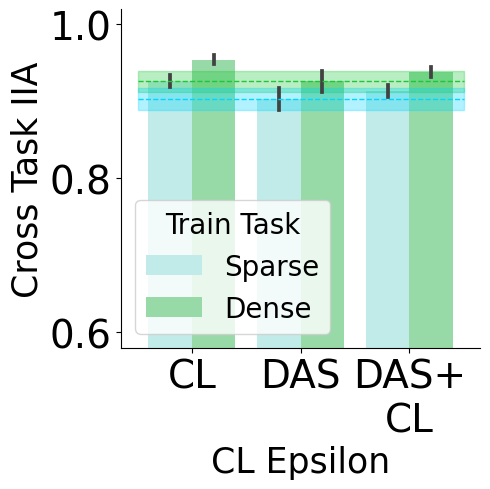

In [218]:
incl_filters = {
    #"mtx_type": ["orthog"],
    "incl_extra": [False], # refers to whether the CL loss is applied to only the masked dimensions or all dimensions
    #"extra_dims": [64], # 16,],
    "mask_dims": [1,],
    "lr": [ 0.05 ],
    #"prop_rank": [1,],
    #"cov_strength": [0], #,1,], # how much do the extraneous dimensions covary with the x and y values,
    #"cl_eps": [50],
    #"task_spacing": ["Sparse"],
    "task_division": ["inner_square"],
}
excl_filters = {
    #"task_spacing": ["Dense"],
}
class_acc_threshold = 0 # filters out MLPs that failed to solve the classification task

rot = 35
x = "loss_type"
y = "cross_actn_acc"
hue = "task_spacing"
mtx_type = "orthog"
leg_title = "Train Task" # " ".join([h.capitalize() for h in hue.split("_")])
if hue=="task_spacing":
    p = {
        "Dense": sns.color_palette("pastel")[color_order[0]],
        "Sparse": sns.color_palette("pastel")[color_order[1]],
    }
    pp = {
        "Dense": sns.color_palette("bright")[color_order[0]],
        "Sparse": sns.color_palette("bright")[color_order[1]],
    }
else:
    p = {k: sns.color_palette("pastel")[color_order[i]] for i,k in enumerate(plot_df[hue].unique())}
    pp = {k: sns.color_palette("bright")[color_order[i]] for i,k in enumerate(plot_df[hue].unique())}
labelsize = 25
ticksize = 28
fontsize = 30
titlesize = 20
legendsize = 20
linewidth = 4

ylabel = "Cross Task IIA" if "cross" in y else "Trained Task IIA" 
ylim = [0.58,1.02]
yticks = [0.6, 0.8, 1.0]
if "acc" not in y:
    if "row" in y:
        ylabel = ylabel.replace("Task IIA", "Row EMD")
        yticks = [0,0.025,0.05, 0.075, 0.1, 0.125, 0.15]
        ylim = [0,0.155]
    else:
        ylabel = ylabel.replace("Task IIA", "EMD")
        yticks = None
        ylim = None
print(y)
iia_threshold = 0


plot_df = full_df.loc[full_df["mtx_type"]==mtx_type].copy()
plot_df = plot_df.loc[(plot_df["class_val_acc"]>class_acc_threshold)&(plot_df["actn_acc"]>iia_threshold)]
for filt,vals in incl_filters.items():
    plot_df = plot_df.loc[plot_df[filt].isin(vals)]
for filt,vals in excl_filters.items():
    plot_df = plot_df.loc[~plot_df[filt].isin(vals)]
plot_df = plot_df.copy()
#combo_df = plot_df.loc[plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]].copy()
#combo_df["cl_eps"] = 0
#combo_df["incl_cl_loss"] = True
#cl_df = combo_df.copy()
#cl_df["incl_actn_loss"] = False
#plot_df = pd.concat([ plot_df, combo_df, cl_df, ])

actn_bools = plot_df["incl_actn_loss"]&~plot_df["incl_cl_loss"]
bloss_acc = dict(plot_df.loc[actn_bools].groupby(hue)[y].mean())
bloss_err = dict(plot_df.loc[actn_bools].groupby(hue)[y].sem())
print("Behavior Only Accuracy", bloss_acc, "+/-", bloss_err)

#fig,axes = plt.subplots(1,2, figsize=(10,5))
temp_df = plot_df.copy()
temp_df["emd"] = temp_df["emd"]/(temp_df["extra_dims"]+1)
temp_df["cross_emd"] = temp_df["cross_emd"]/(temp_df["extra_dims"]+1)
g = sns.catplot(
    x=x, y=y,
    hue=hue,
    data=temp_df,
    ax=ax,
    palette=p,
    kind="bar",
    legend=False,
    errorbar="se",
)
ax = plt.gca()
title = ax.get_title() 

# Baseline
err_alpha = 0.3
linewidth = 1
xs = list(range(len(set(temp_df[x]))))
xs = [np.min(xs)-0.5] + xs + [np.max(xs)+0.5]
xs = np.asarray(xs)
for i,k in enumerate(bloss_acc):
    acc = bloss_acc[k]
    err = bloss_err[k]
    color = pp[k]
    ys = np.asarray([acc for _ in xs])
    plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
    plt.fill_between(xs, ys-err, ys+err, alpha=err_alpha, color=color, )

#plt.title("DAS + CL Loss", fontsize=titlesize)
if ylim is not None:
    plt.ylim(ylim)
#xlabel = " ".join([lab.capitalize() for lab in x.split("_")])
#plt.xlabel(xlabel, fontsize=labelsize)
plt.xlabel("CL Epsilon", fontsize=labelsize)
plt.ylabel(ylabel, fontsize=labelsize)
#plt.xticks(xticks, rotation=rot, fontsize=ticksize)
plt.xticks(fontsize=ticksize)
if yticks is None:
    plt.yticks(fontsize=ticksize)
else:
    plt.yticks(yticks, fontsize=ticksize)
plt.title(
    ax.get_title(),
    fontsize=titlesize
)
plt.legend(
    title=leg_title,
    fontsize=legendsize,
    title_fontsize=legendsize
)

## Baseline
#xs = list(range(len(set(plot_df[x]))))
#xs = [np.min(xs)-1] + xs + [np.max(xs)]
#xs = np.asarray(xs)
#for i,k in enumerate(bloss_acc):
#    acc = bloss_acc[k]
#    err = bloss_err[k]
#    color = p[i]
#    ys = np.asarray([acc for _ in xs])
#    plt.plot(xs, ys, "--", color=color, alpha=1, linewidth=linewidth)
#    #plt.fill_between(xs, ys-err, ys+err, alpha=0.2, color=color, )

plt.tight_layout()
#plt.savefig(f"figs/ood_ablations_c{col}_r{row}_{y}.png", dpi=600, bbox_inches="tight")
#plt.savefig(f"figs/ood_ablations_c{col}_r{row}_{y}.pdf", dpi=600, bbox_inches="tight")
plt.show()

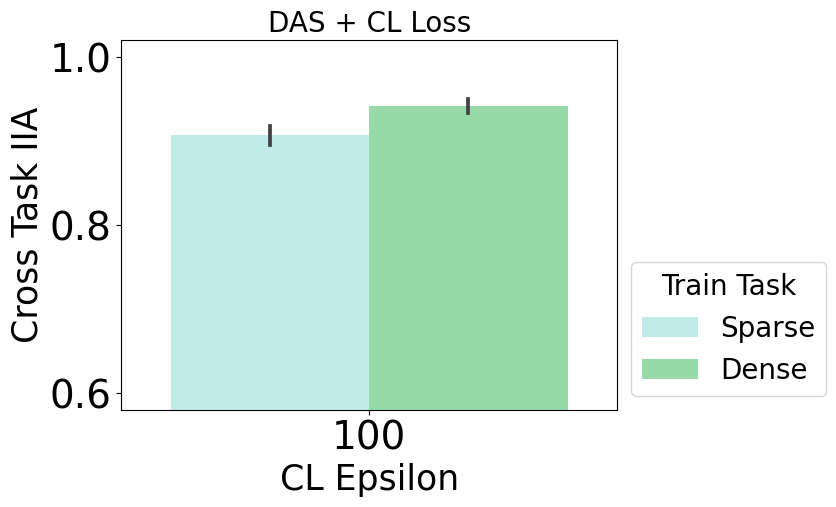

In [215]:
fig = plt.figure()
temp_df = plot_df.loc[plot_df["incl_cl_loss"]&plot_df["incl_actn_loss"]].sort_values(by=x, ascending=False)
ax = plt.gca()
sns.barplot(x=x, y=y, hue=hue, data=temp_df, ax=ax, palette=p)
plt.title("DAS + CL Loss", fontsize=titlesize)
plt.ylim(ylim)
#xlabel = " ".join([lab.capitalize() for lab in x.split("_")])
#plt.xlabel(xlabel, fontsize=labelsize)
plt.xlabel("CL Epsilon", fontsize=labelsize)
plt.ylabel("Cross Task IIA", fontsize=labelsize)
#plt.xticks(xticks, rotation=rot, fontsize=ticksize)
plt.xticks(fontsize=ticksize)
plt.yticks(yticks, fontsize=ticksize)
plt.legend(
    loc="lower left",
    bbox_to_anchor=(1,0),
    title=leg_title,
    fontsize=legendsize,
    title_fontsize=legendsize
)
plt.savefig("figs/ood_legend.png", dpi=600,bbox_inches="tight")
plt.show()
